# SEIR Model

In [9]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

# Other
import copy
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.seir_model import SEIRModel
from src.plotting import plot_predictions
from src.utils import get_covid_data, get_all_covid_data, get_prov_gov_policies

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Load data

In [2]:
# Read in data
start_date = date(day=8, month=3, year=2020)
covid_data = get_all_covid_data(level="prov").query("date >= @start_date")
end_date = covid_data["date"].max()

# Filter only provinces of interest
provinces = ["Alberta", "BC", "Manitoba", "Ontario", "Quebec", "Saskatchewan"]
covid_data = covid_data.query("province in @provinces")

covid_data.head(10)

province        date  cumulative_cases  cumulative_recovered  \
43  Alberta  2020-03-08                 4                     0   
44  Alberta  2020-03-09                14                     0   
45  Alberta  2020-03-10                14                     0   
46  Alberta  2020-03-11                19                     0   
47  Alberta  2020-03-12                23                     0   
48  Alberta  2020-03-13                29                     0   
49  Alberta  2020-03-14                39                     0   
50  Alberta  2020-03-15                56                     0   
51  Alberta  2020-03-16                74                     0   
52  Alberta  2020-03-17                97                     0   

    cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
43                  0             4                    2       0          0   
44                  0            14                   10       0          0   
45                  0            14                    0       0          0   
46                  0            19                    5       0          0   
47                  0            23                    4       0          0   
48                  0            29                    6       0          0   
49                  0            39                   10       0          0   
50                  0            56                   17       0          0   
51                  0            74                   18       0          0   
52                  0            97                   23       0          0   

    cases  population  removed  cumulative_removed  susceptible  \
43      2     4421876        0                   0      4421872   
44     10     4421876        0                   0      4421862   
45      0     4421876        0                   0      4421862   
46      5     4421876        0                   0      4421857   
47      4     4421876        0                   0      4421853   
48      6     4421876        0                   0      4421847   
49     10     4421876        0                   0      4421837   
50     17     4421876        0                   0      4421820   
51     18     4421876        0                   0      4421802   
52     23     4421876        0                   0      4421779   

    percent_susceptible  
43             0.999999  
44             0.999997  
45             0.999997  
46             0.999996  
47             0.999995  
48             0.999993  
49             0.999991  
50             0.999987  
51             0.999983  
52             0.999978

## SEIR model parameter estimation

In [3]:
%%time

# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

for province in provinces:
    # Get province data
    province_data = covid_data.query('province == @province')

    # Fit SEIR model
    model = SEIRModel(lam=1, method = 'L-BFGS-B', verbose=True)
    model.fit(province_data)    
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

Wall time: 1min 39s


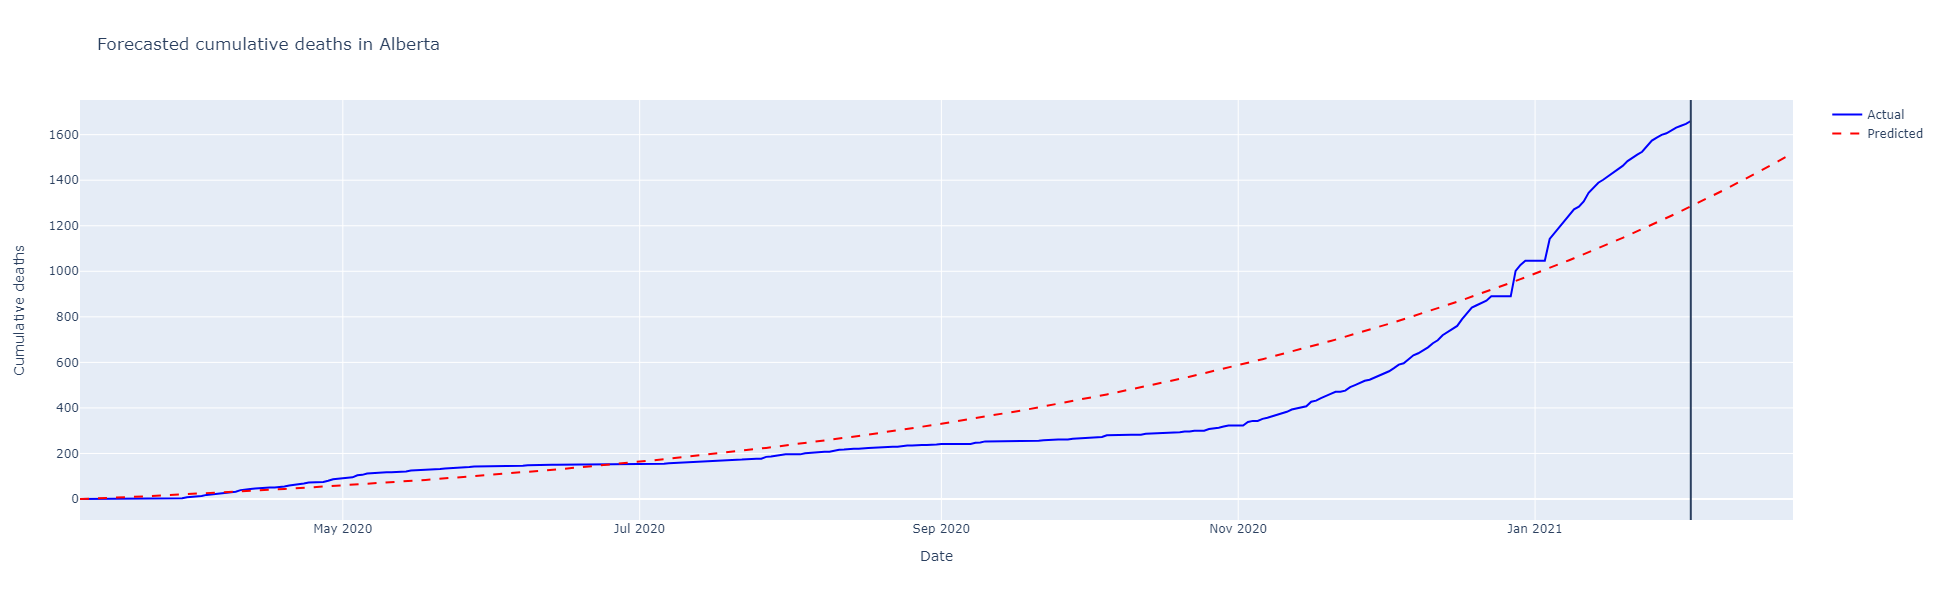

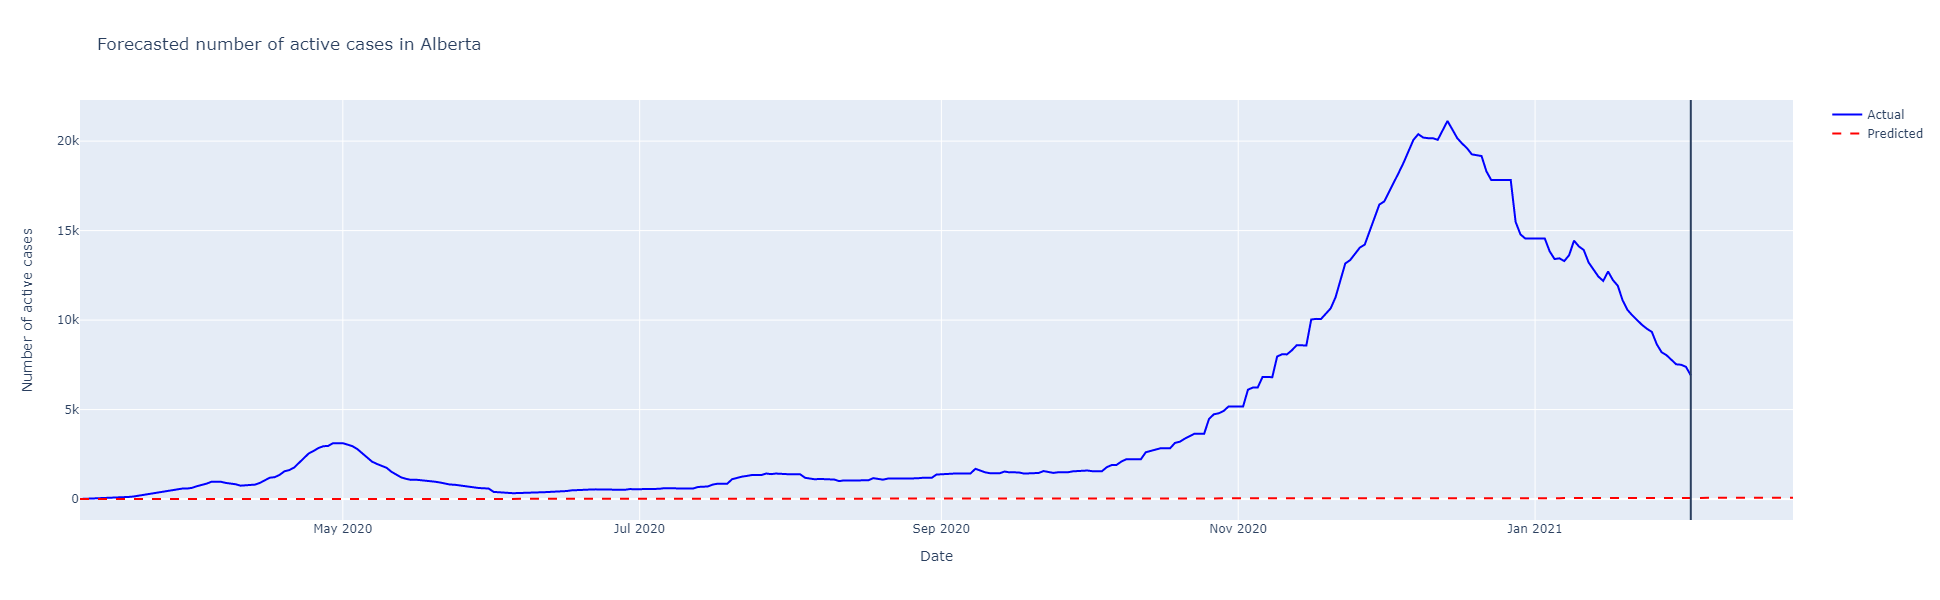

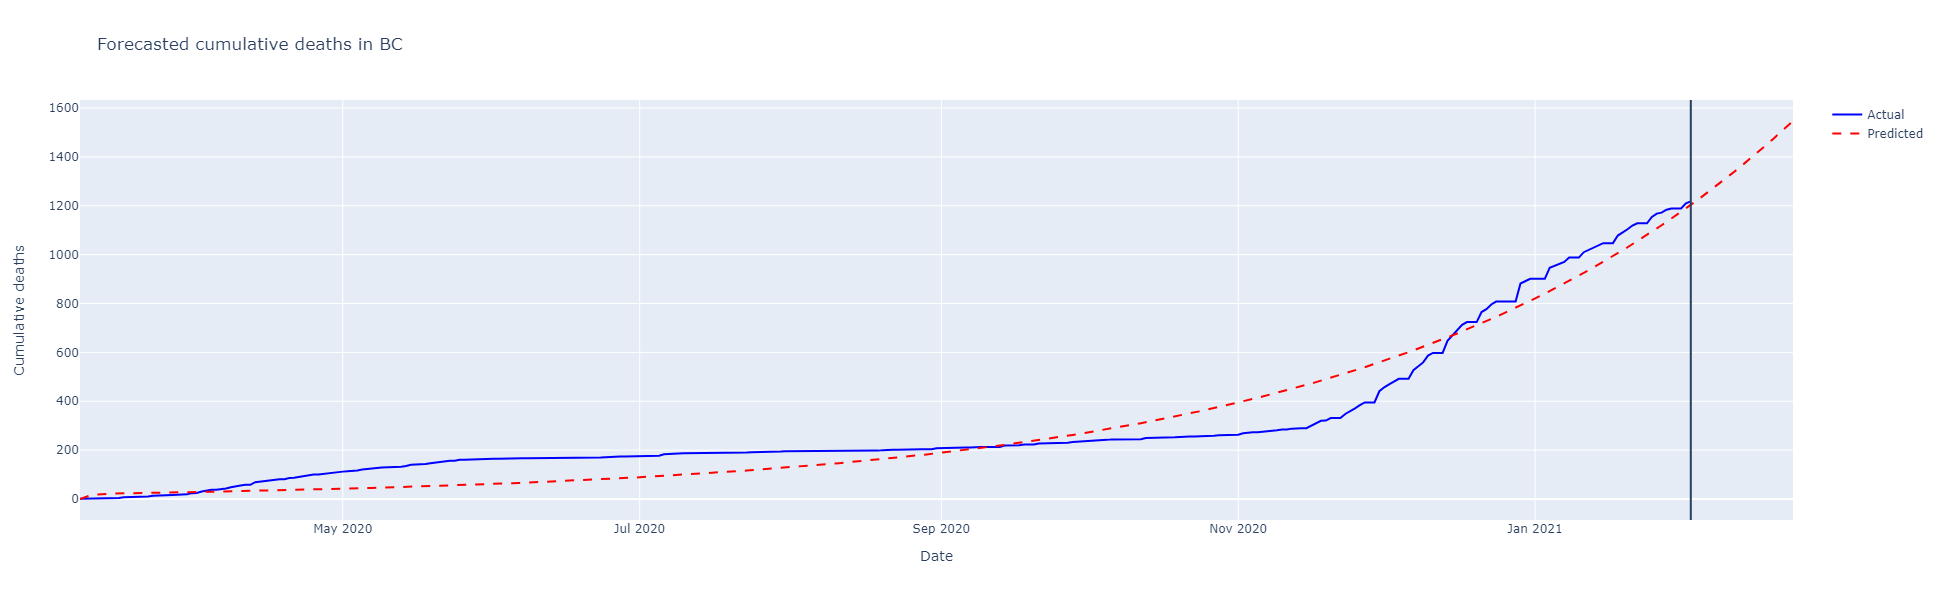

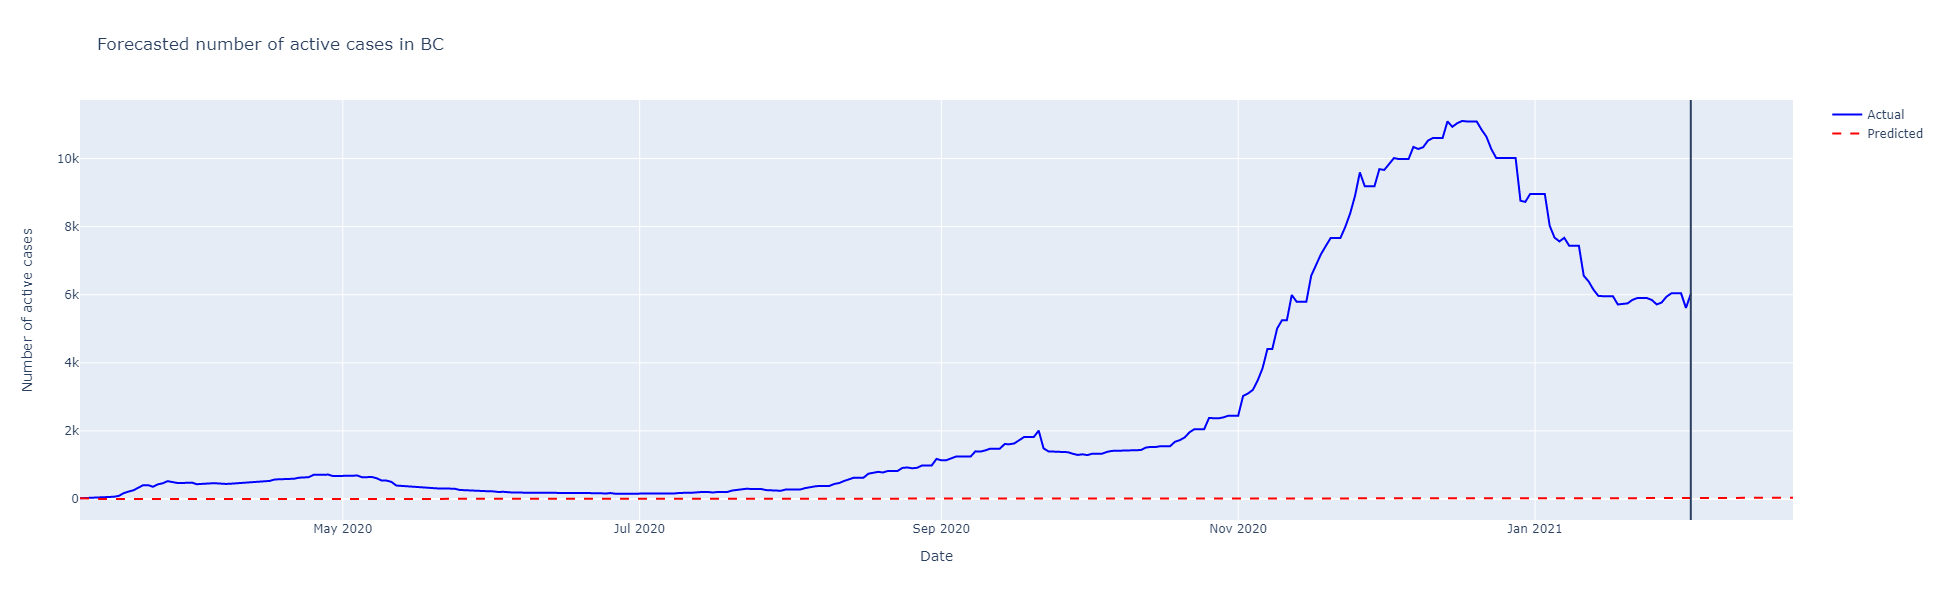

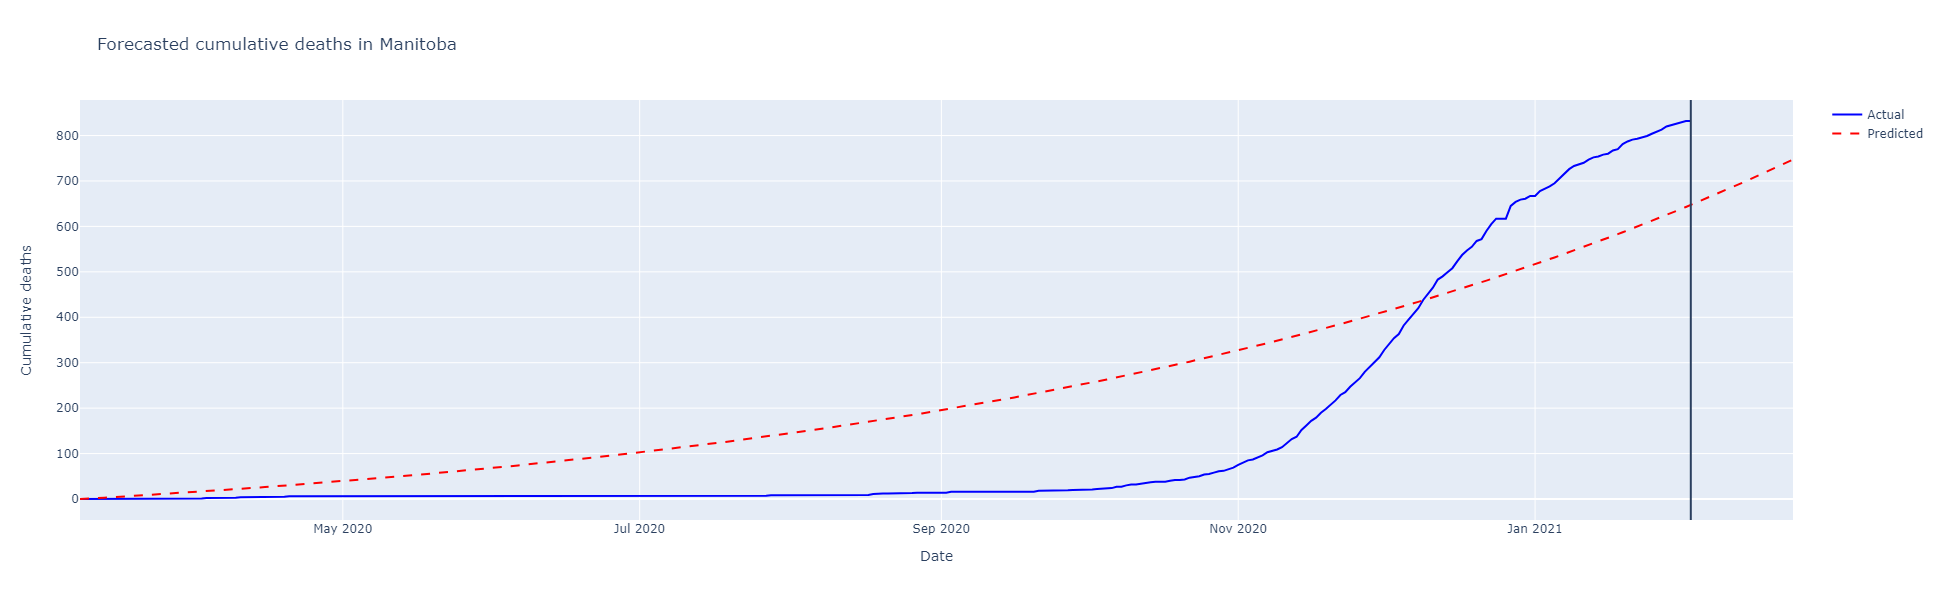

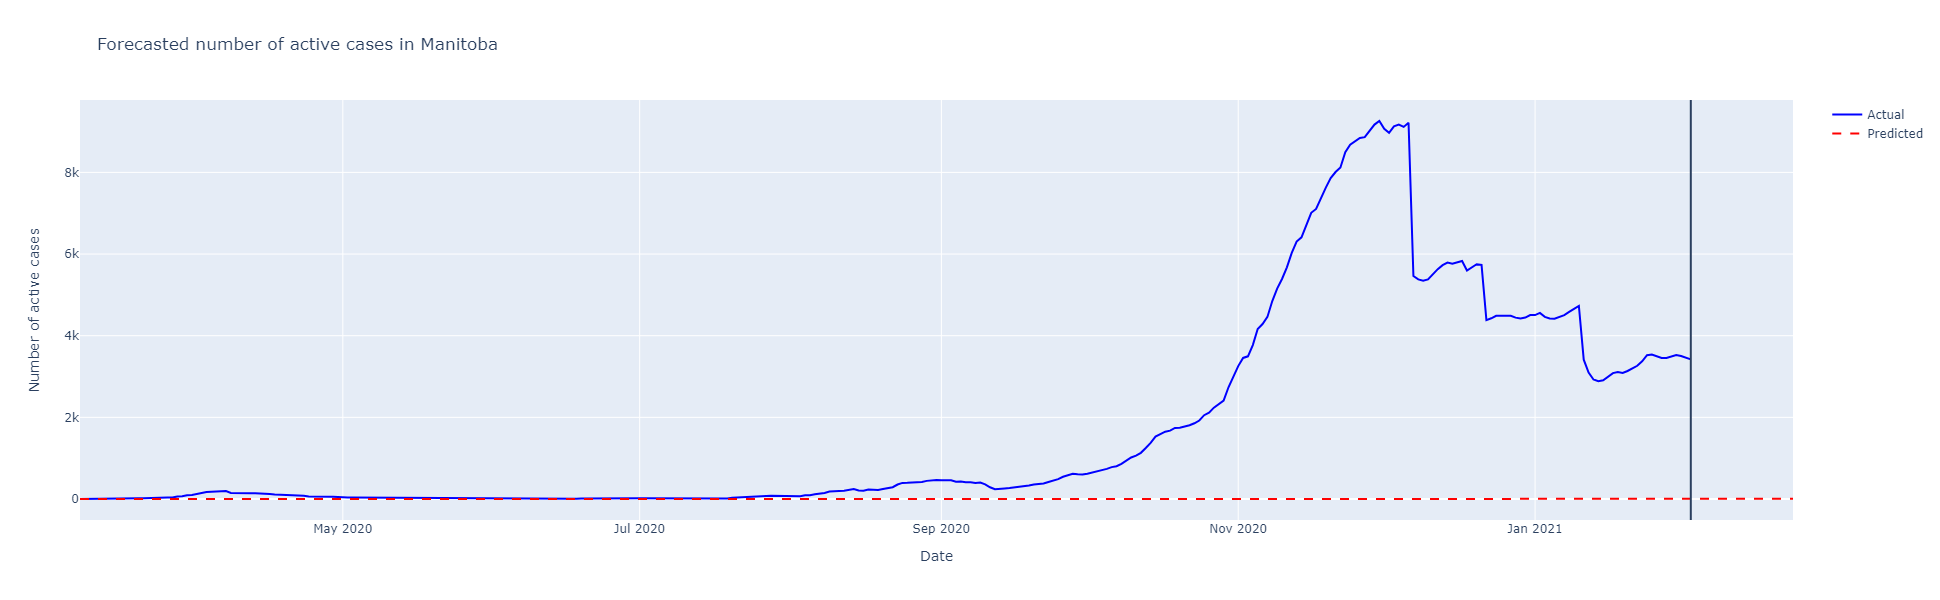

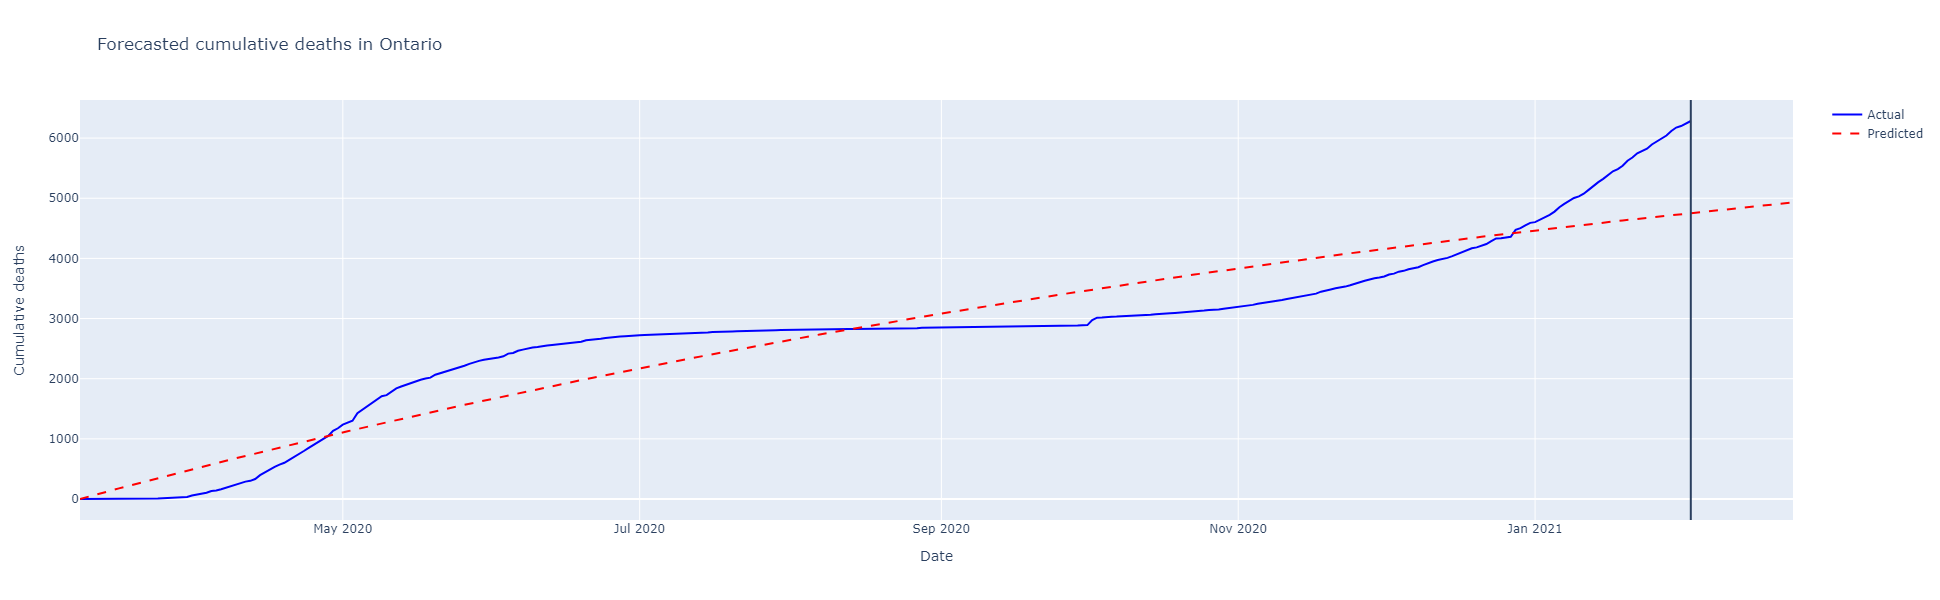

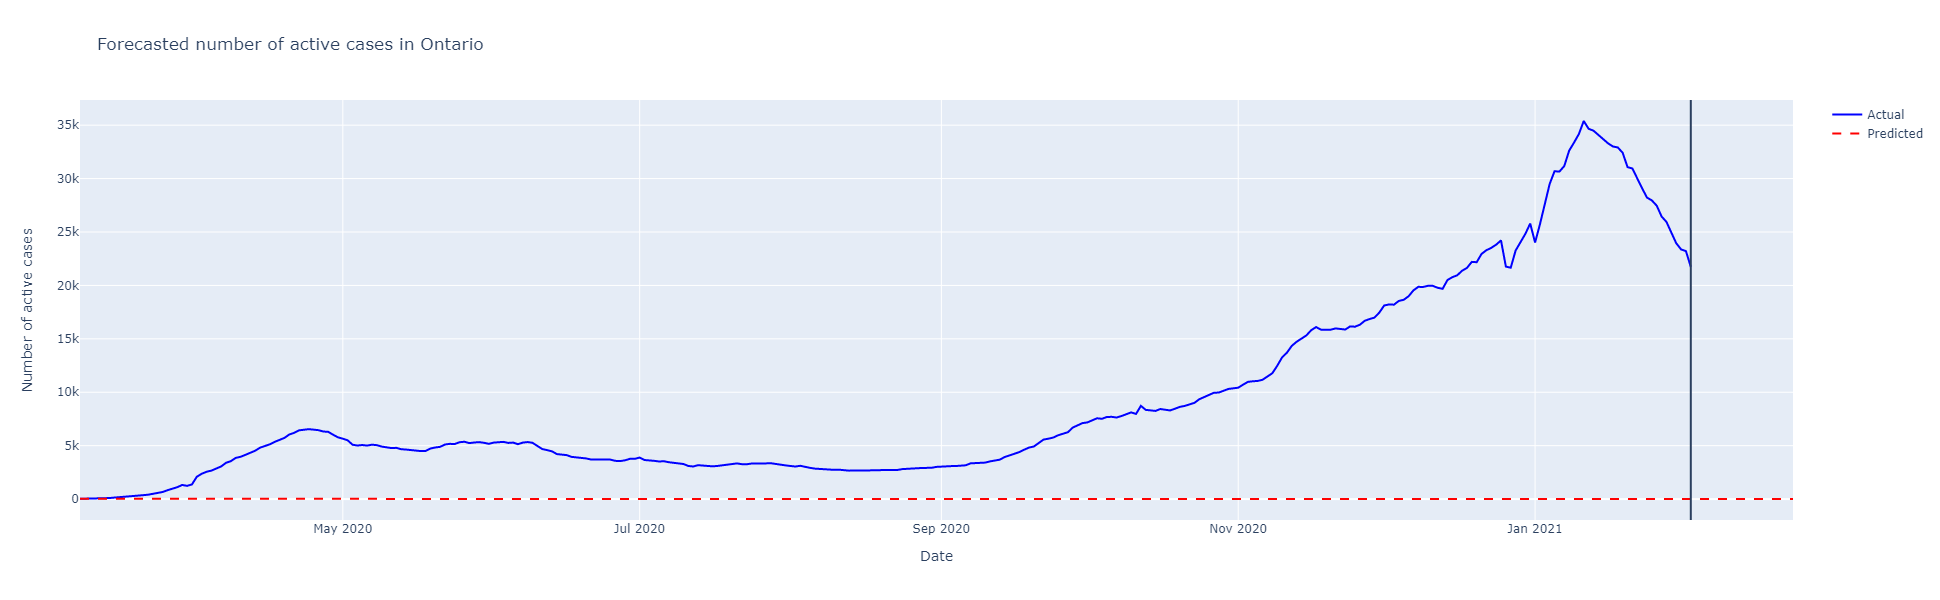

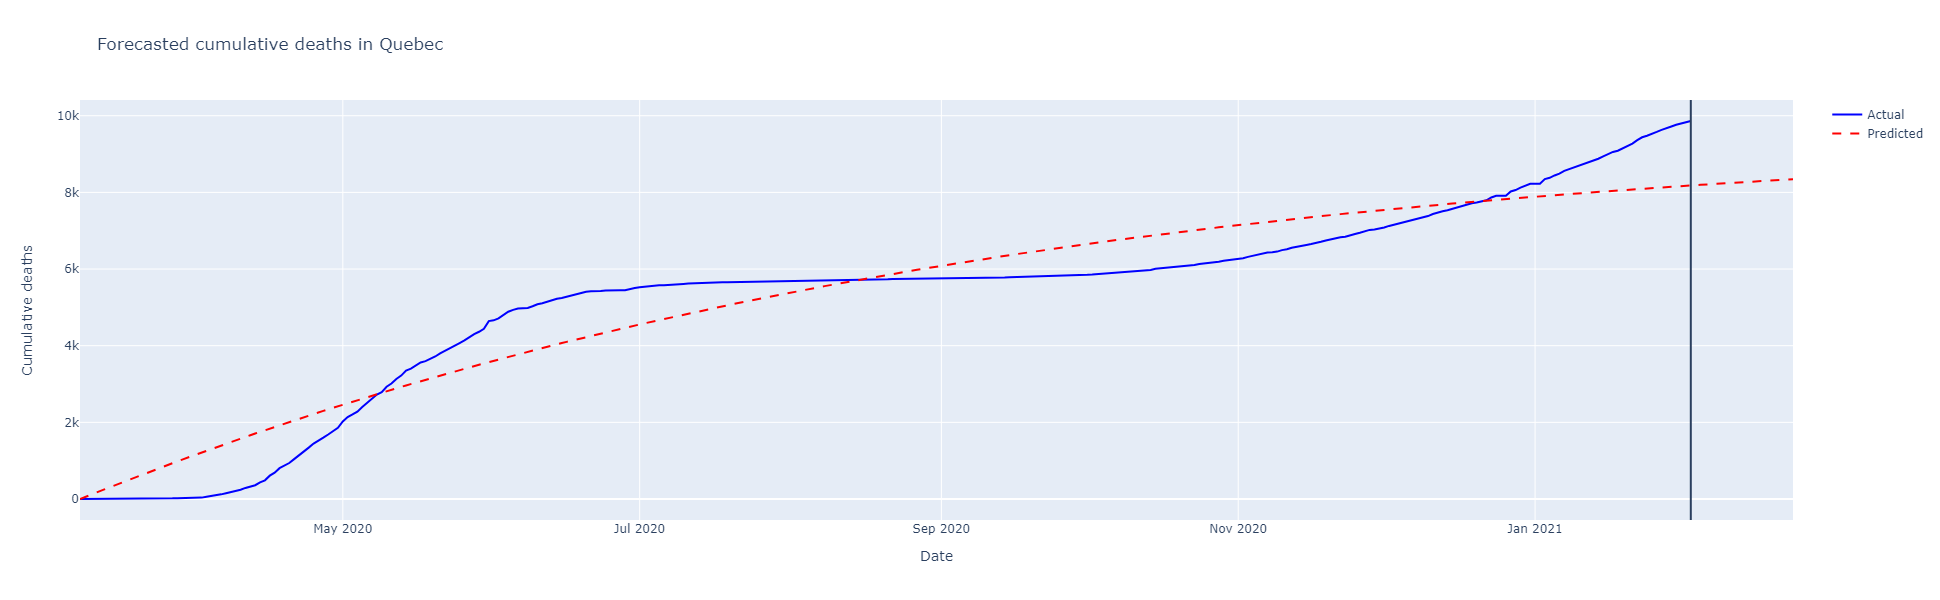

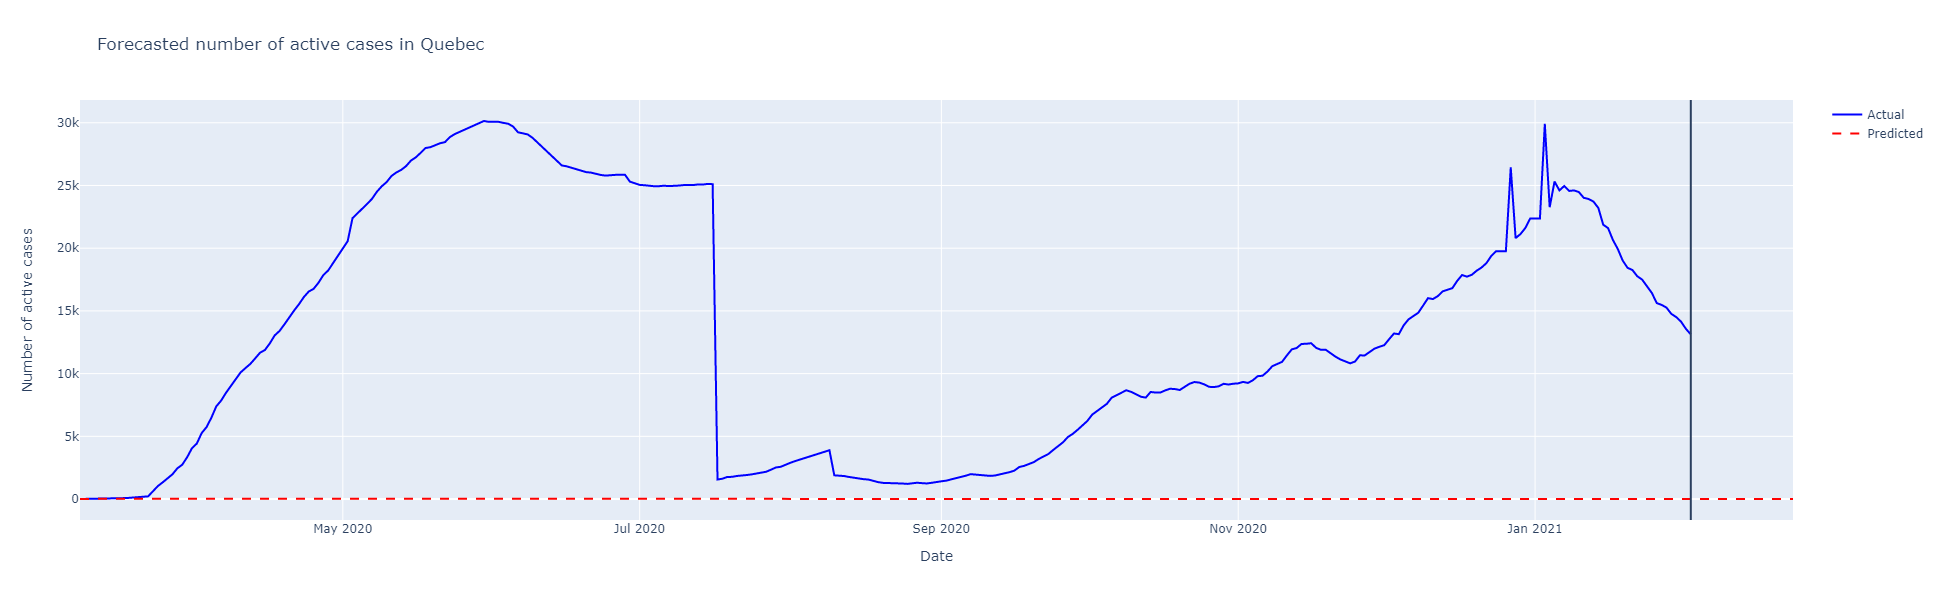

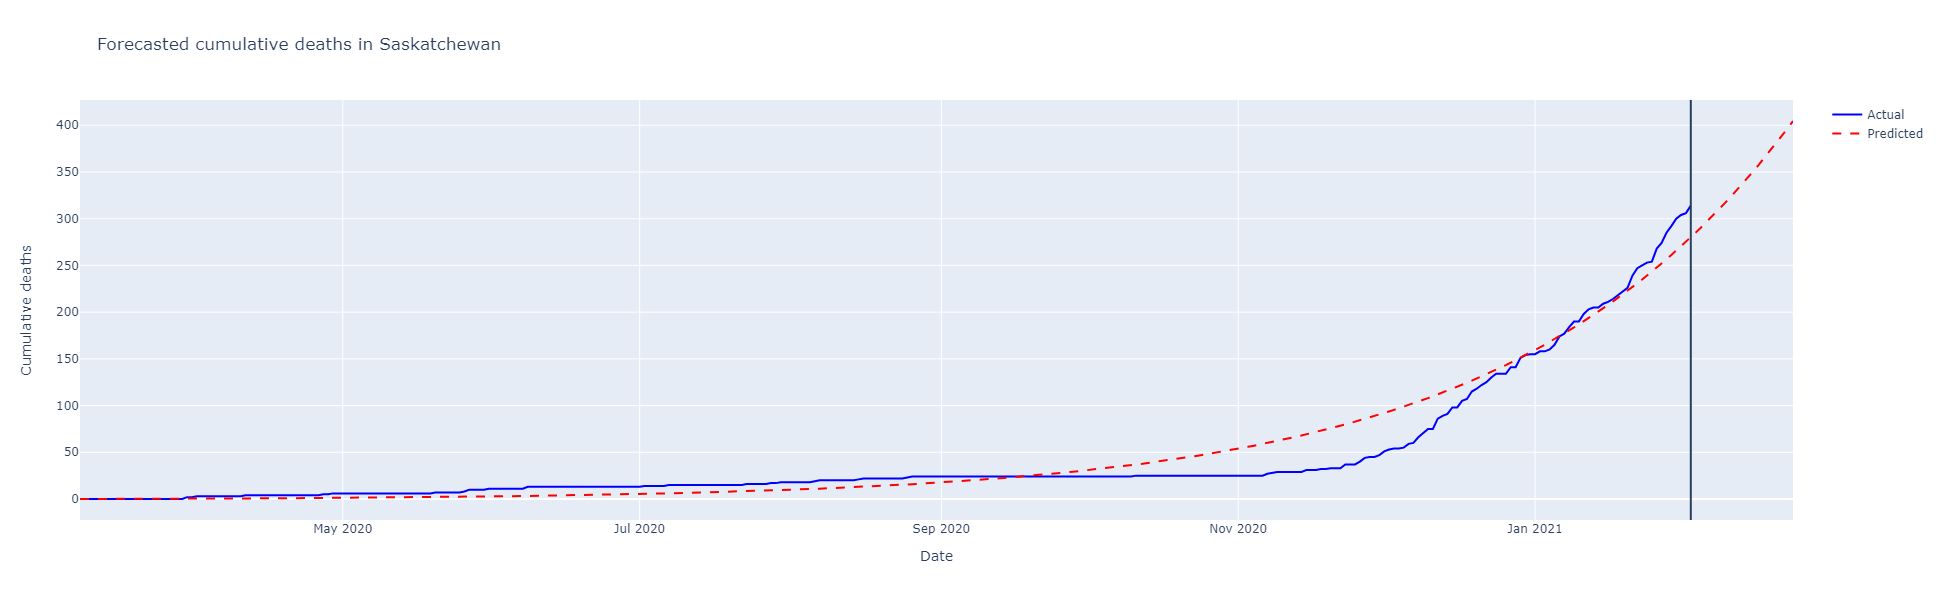

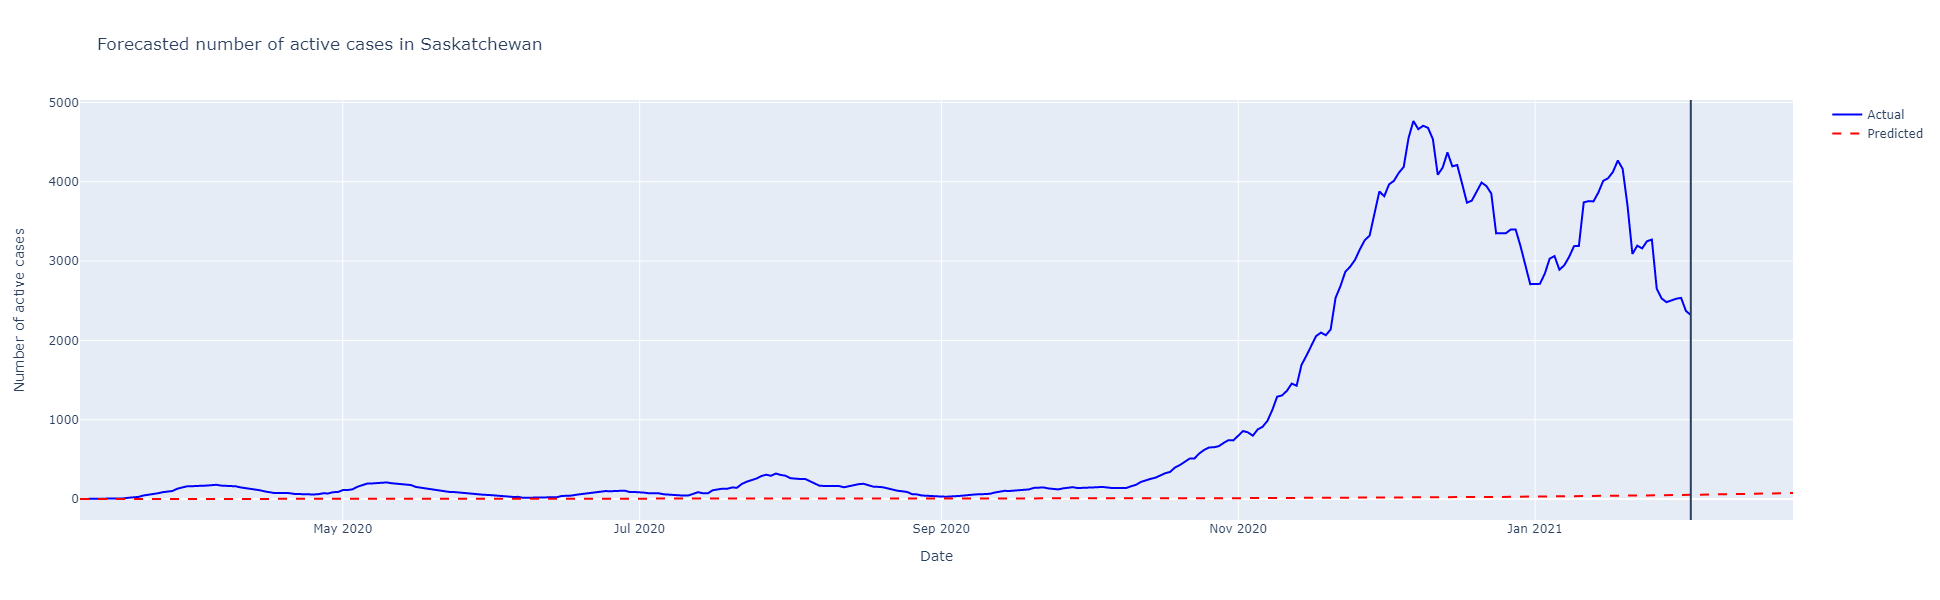

In [4]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative deaths",
        title=f"Forecasted cumulative deaths in {province}",
        height=600,
        include_ci=False,
    )

    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Number of active cases",
        title=f"Forecasted number of active cases in {province}",
        height=600,
    )

## SEIR model parameter estimation with time varying parameters

In this variation we allow the parameter $\beta$ which controls the movement of compartment S to E to vary with time. This allows to the SEIR to model the data under changing policies and is more realistic to allow changing rates of infections at different points in time.

In [5]:
%%time

# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

date_splits = [date(year=2020, month=3, day=8), date(year=2020, month=6, day=1), date(year=2020, month=9, day=1), date(year=2020, month=11,day=1), date(year=2020, month=12, day=15), date(year=2021, month=1, day=3)]

for province in provinces:
    # Get province data
    province_data = covid_data.query('province == @province')

    # Fit SEIR model
    model = SEIRModel(lam=1, method = 'L-BFGS-B', date_splits = date_splits, verbose=True)
    model.fit(province_data)    
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

ValueError: array length 268 does not match index length 332

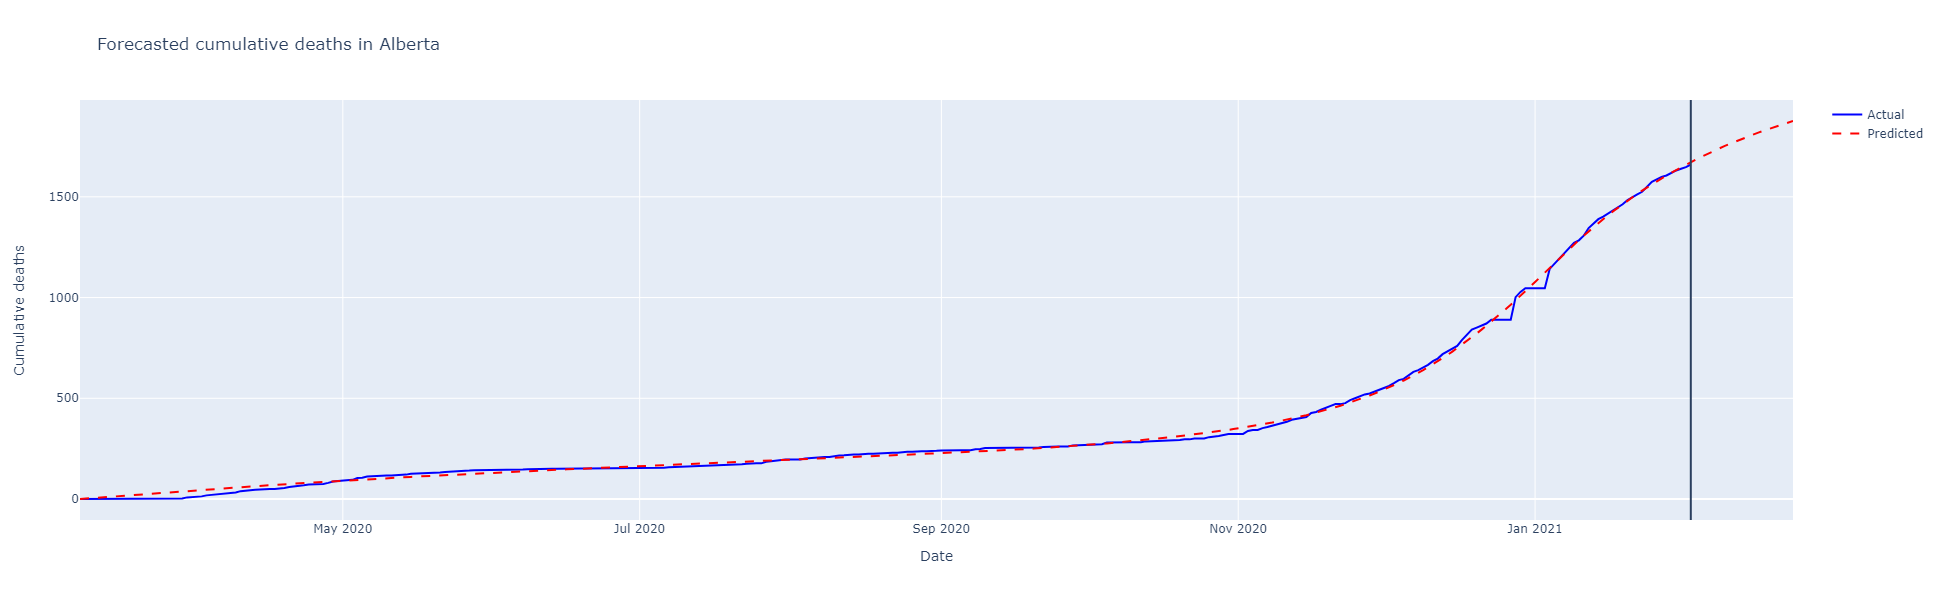

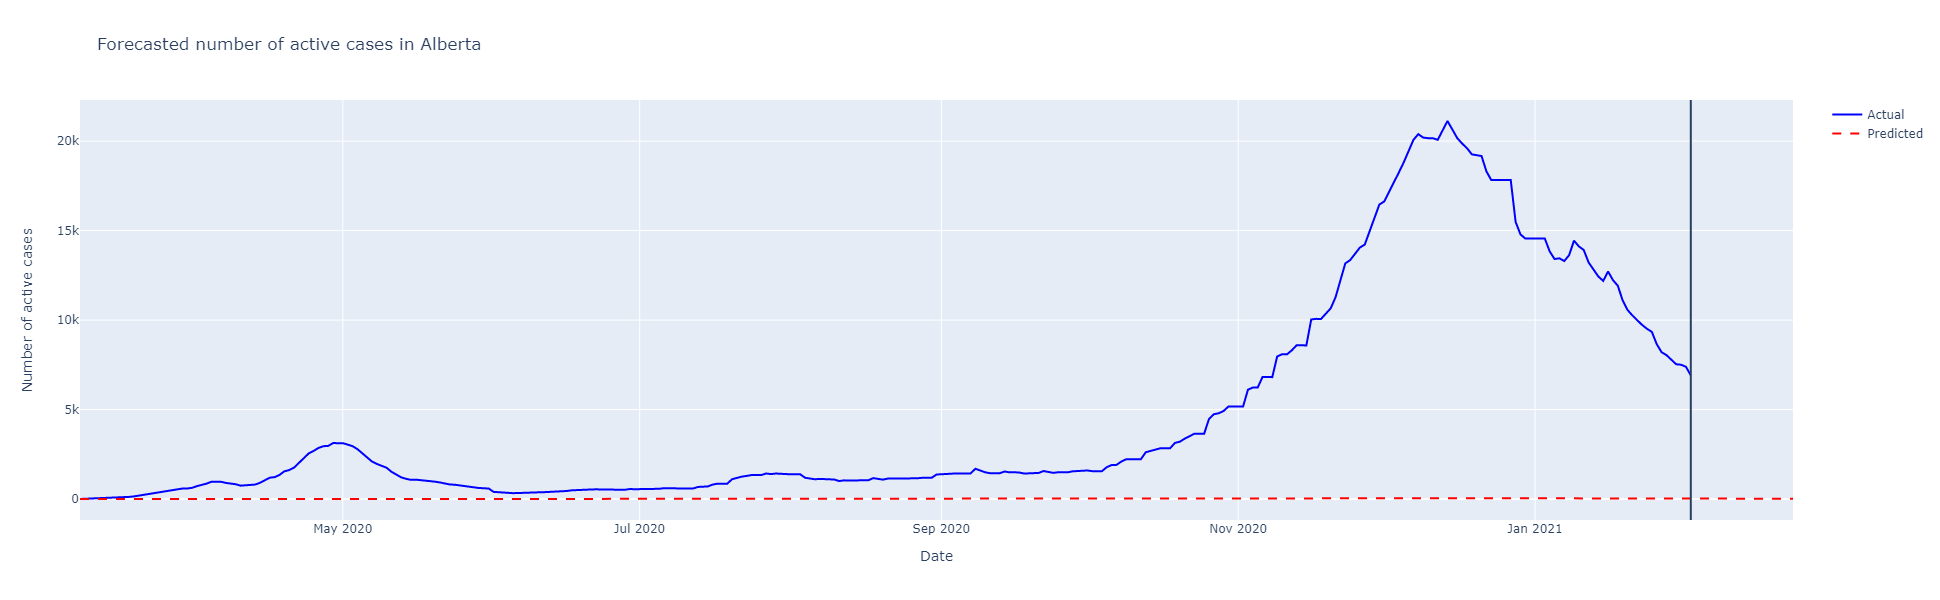

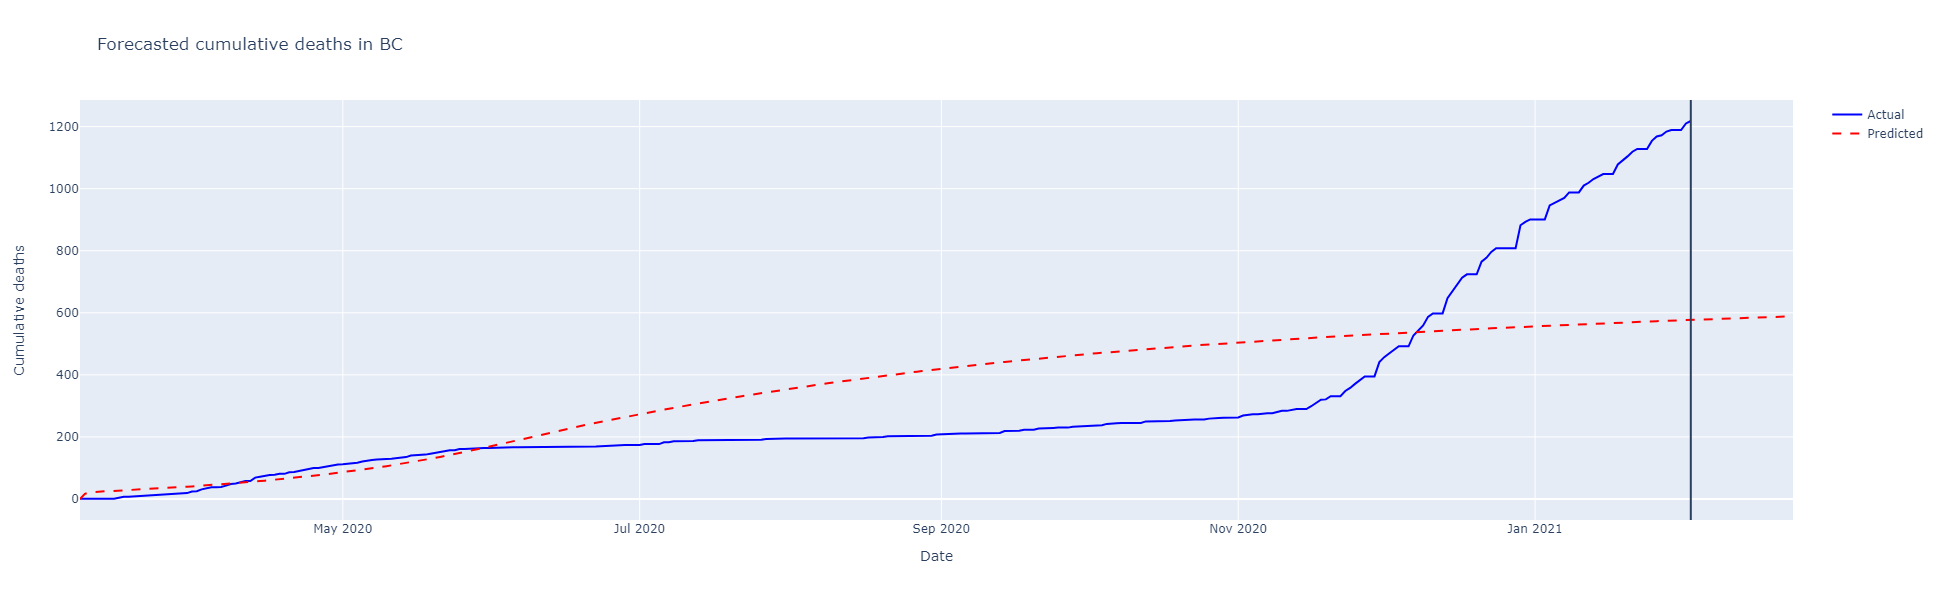

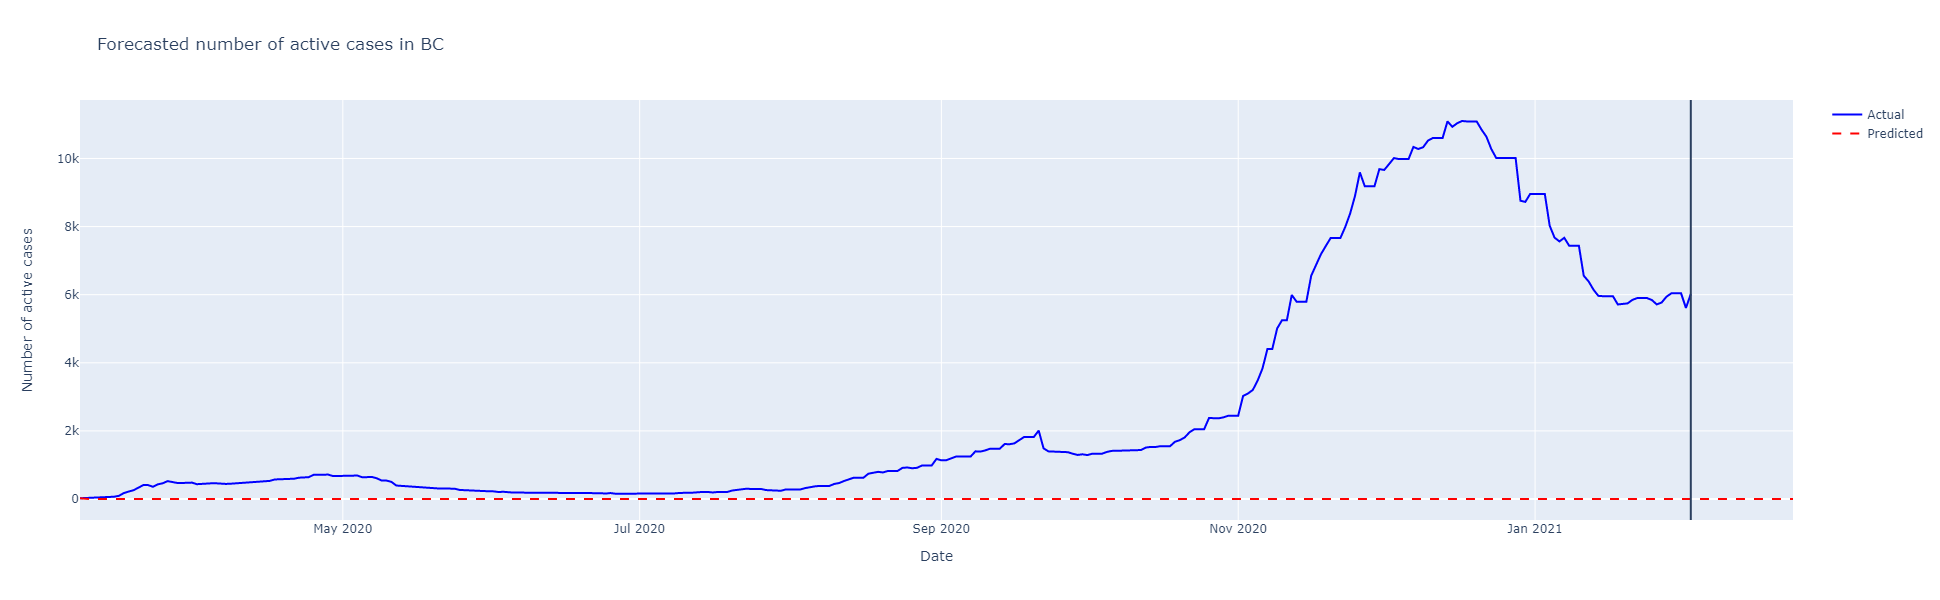

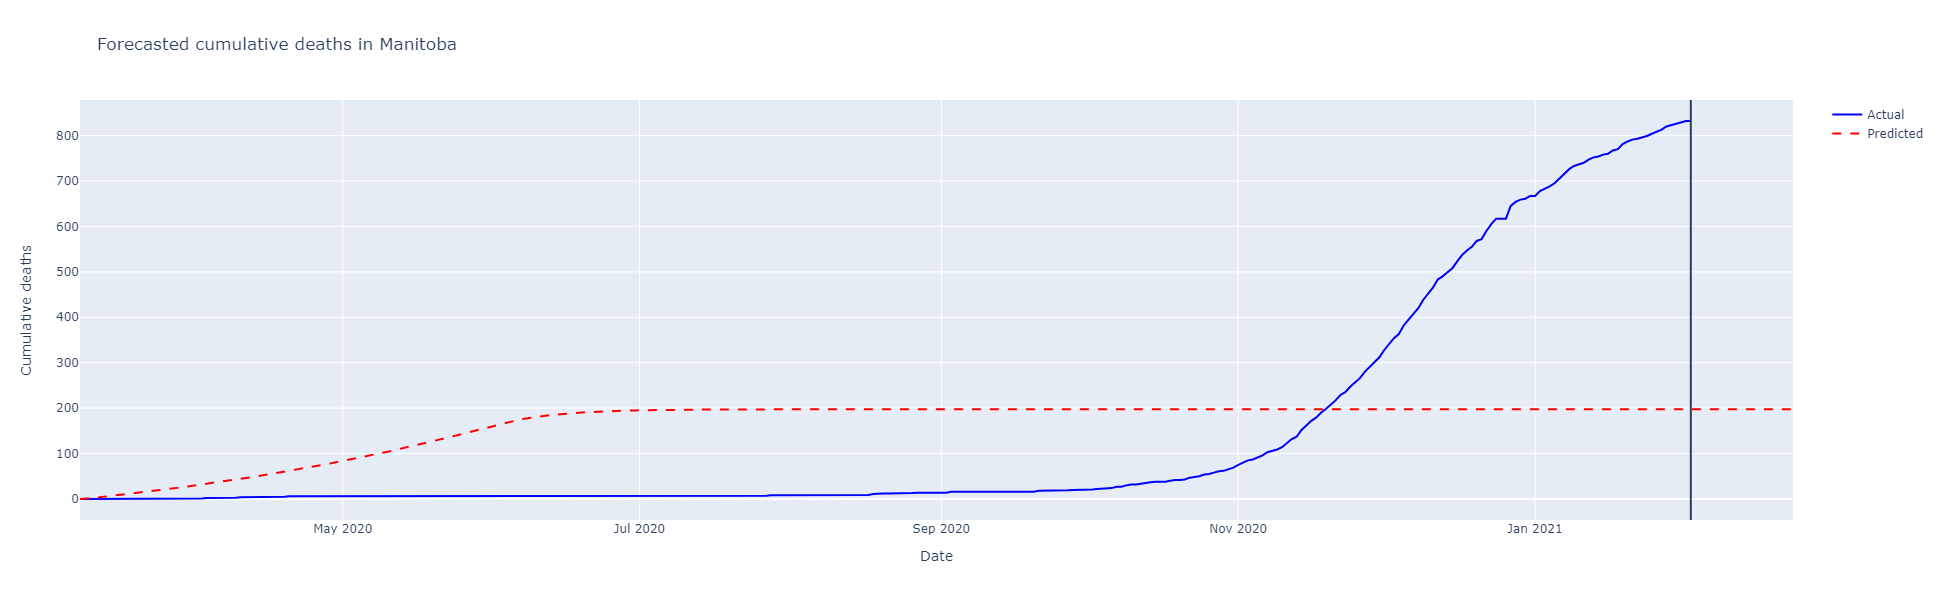

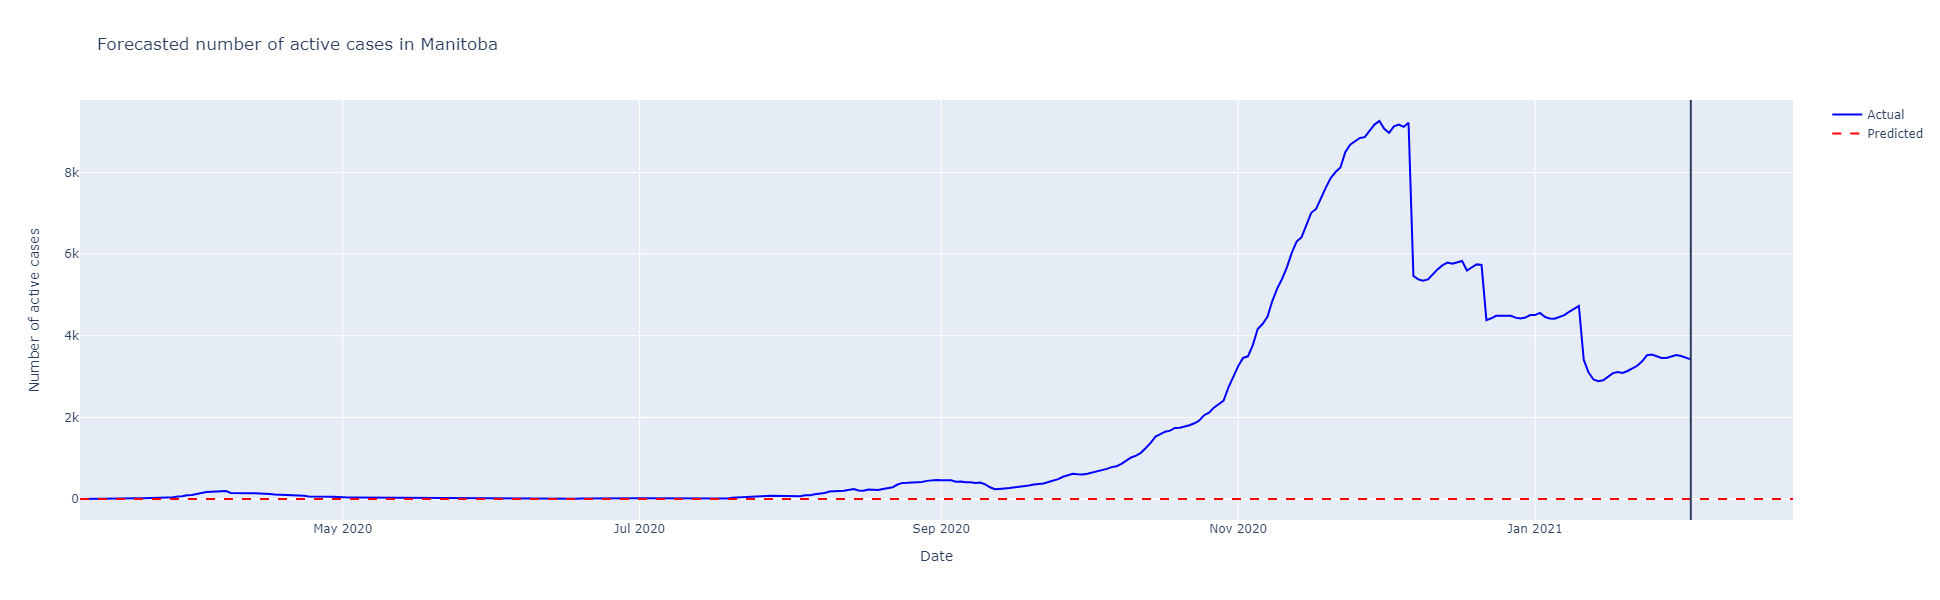

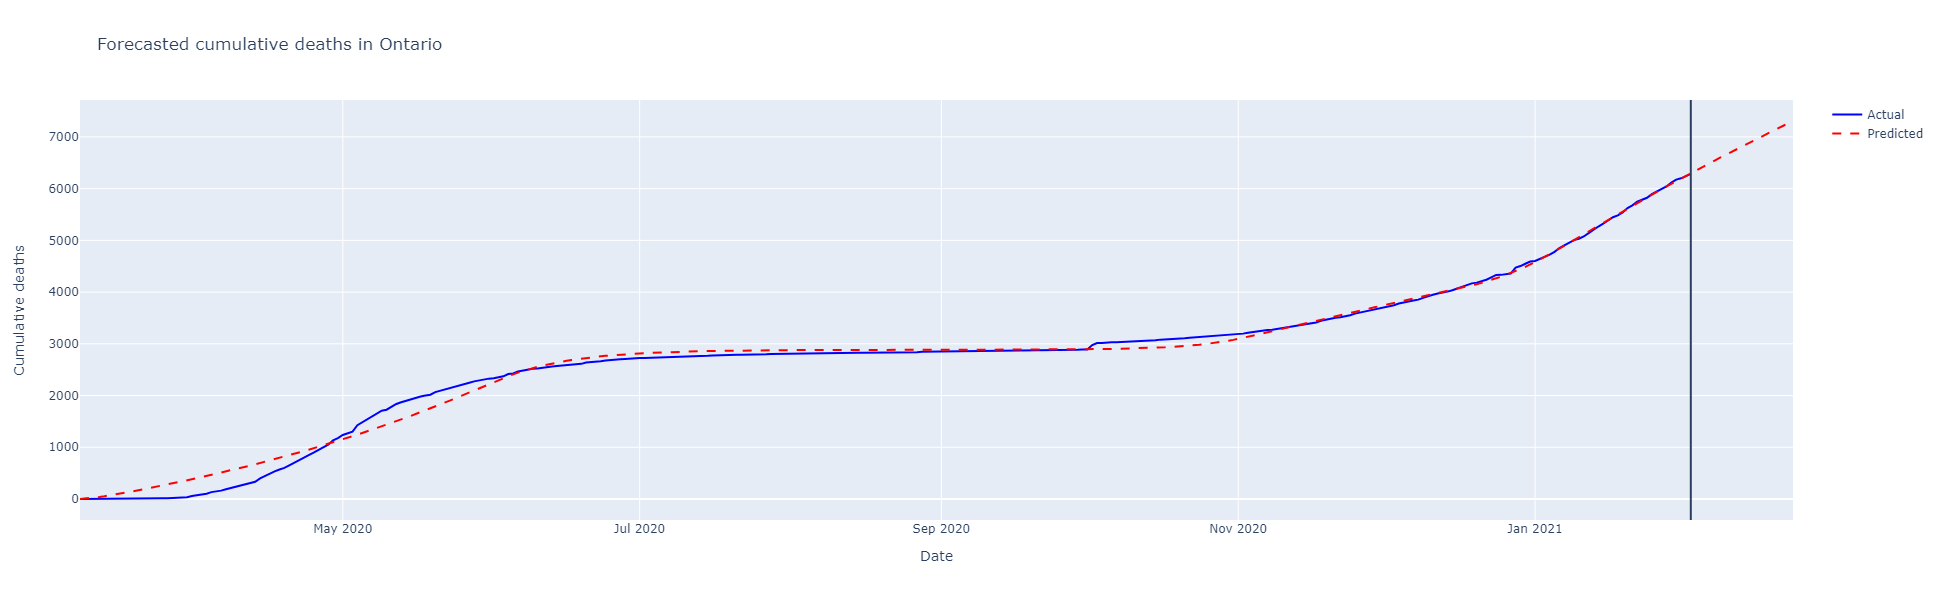

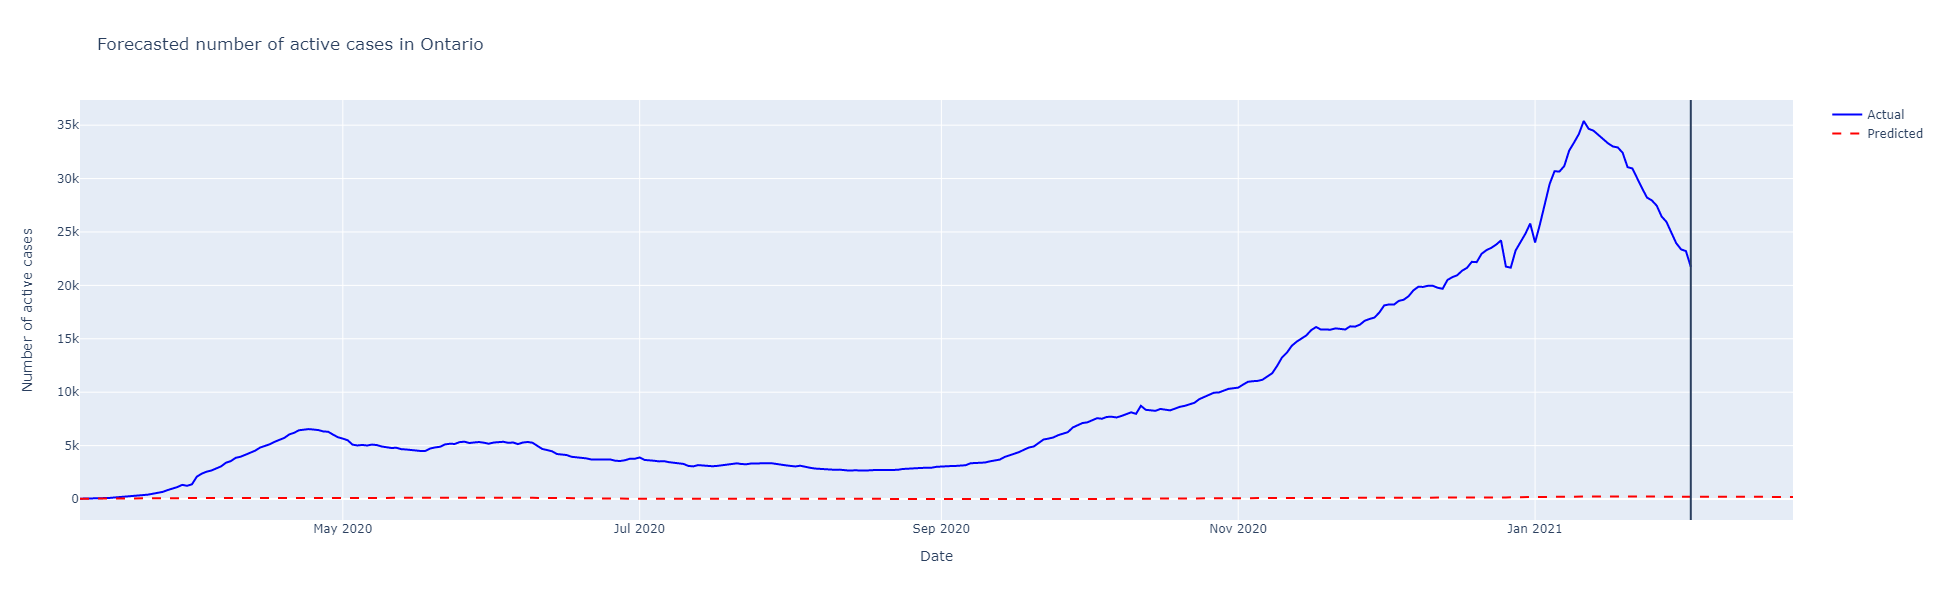

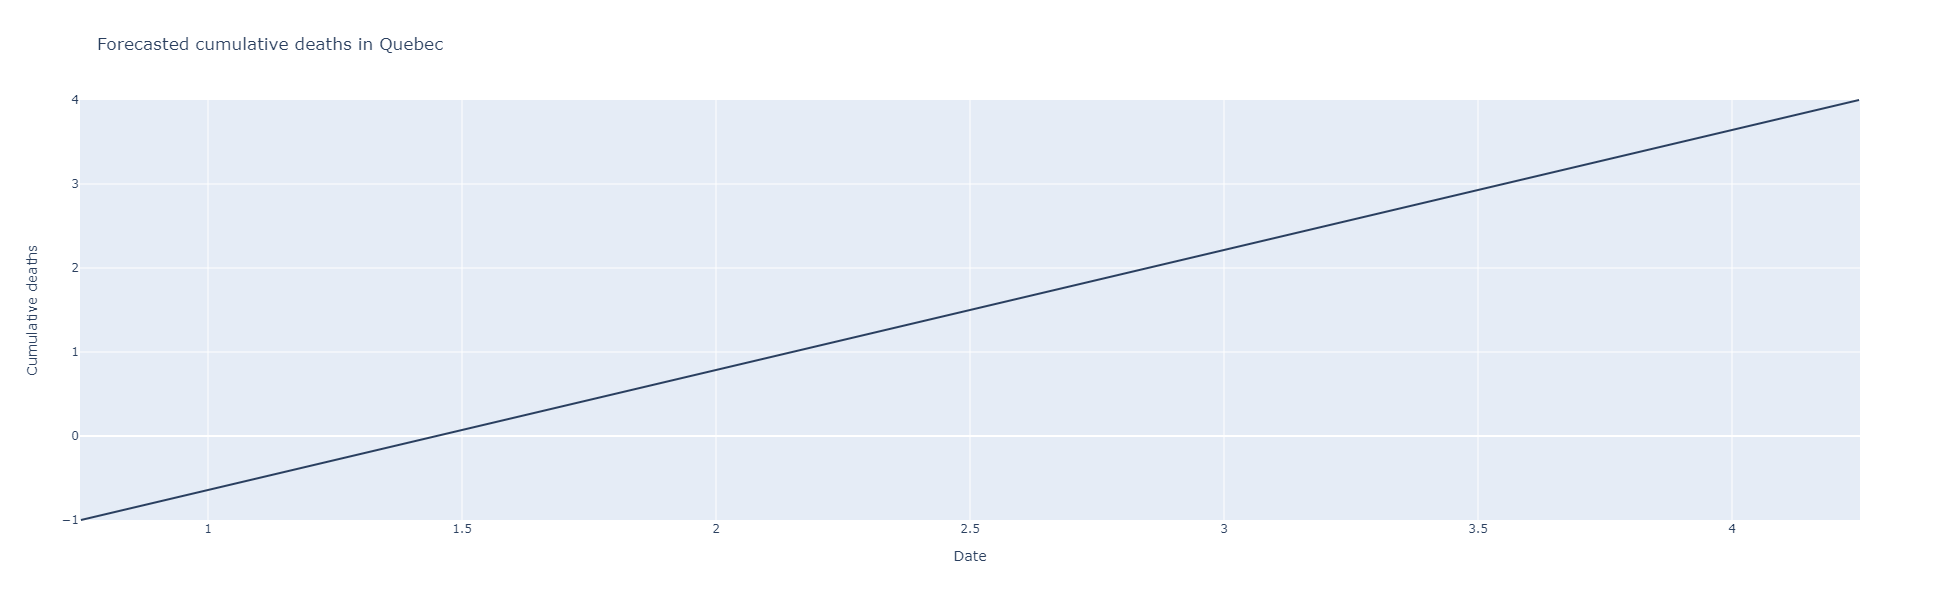

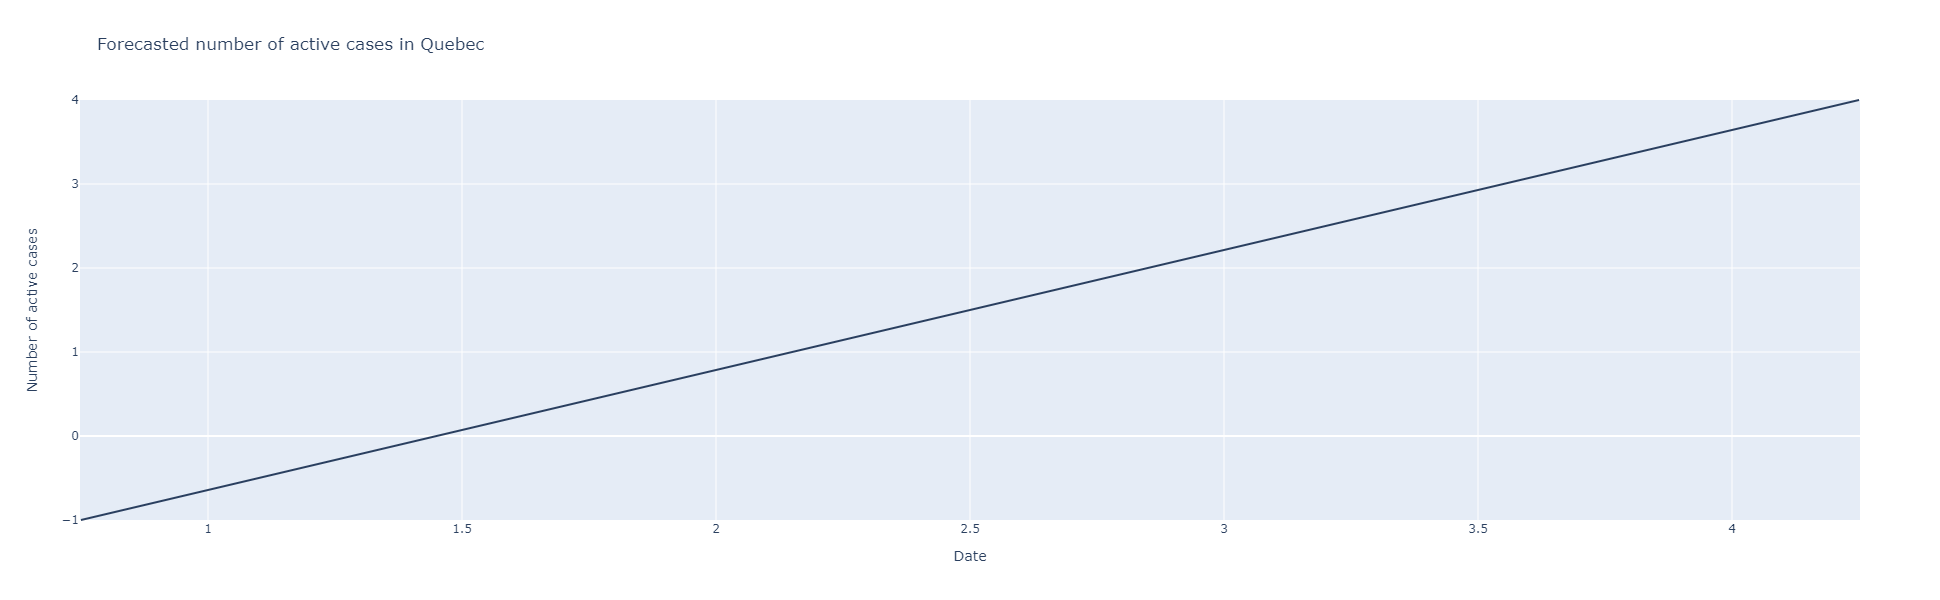

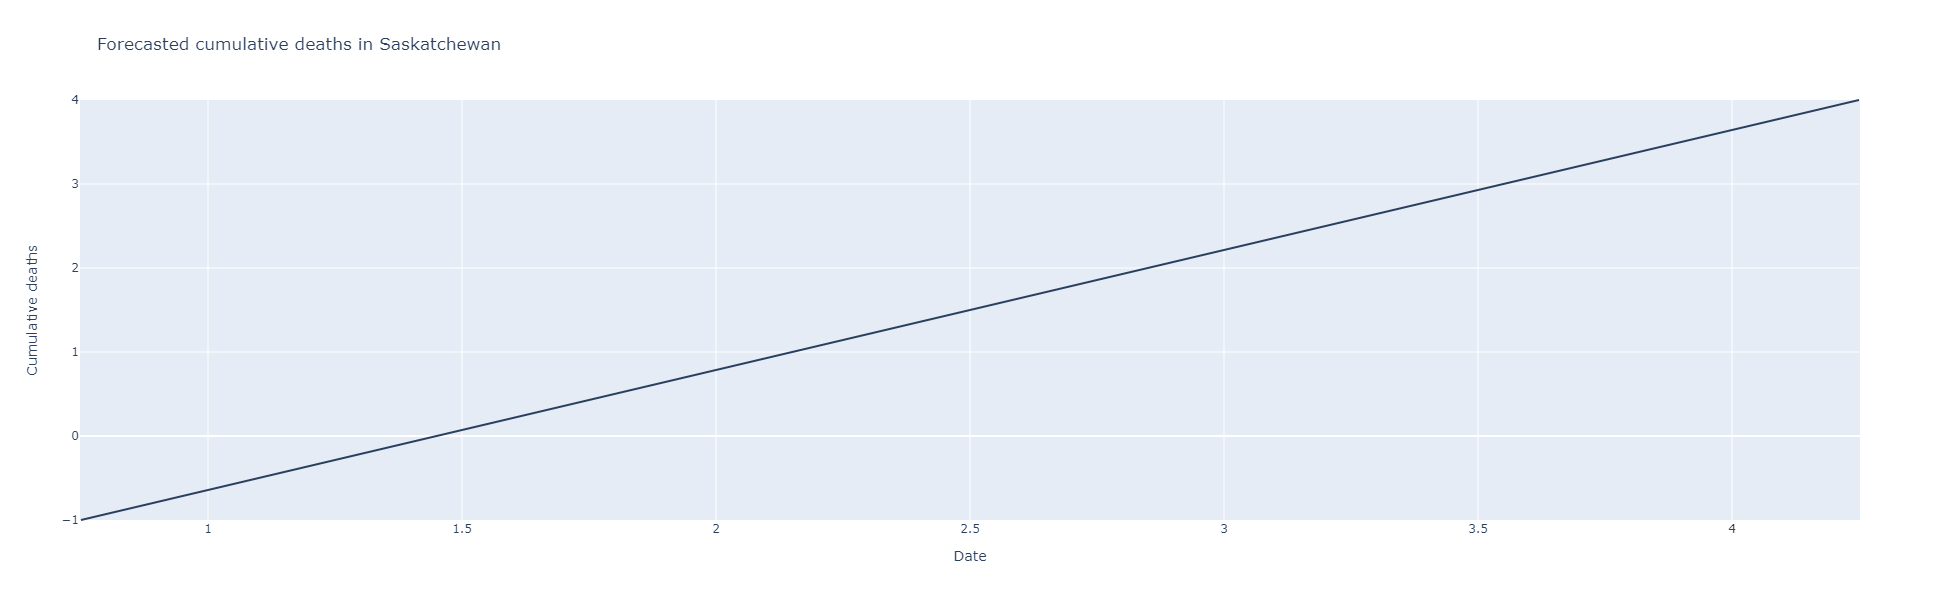

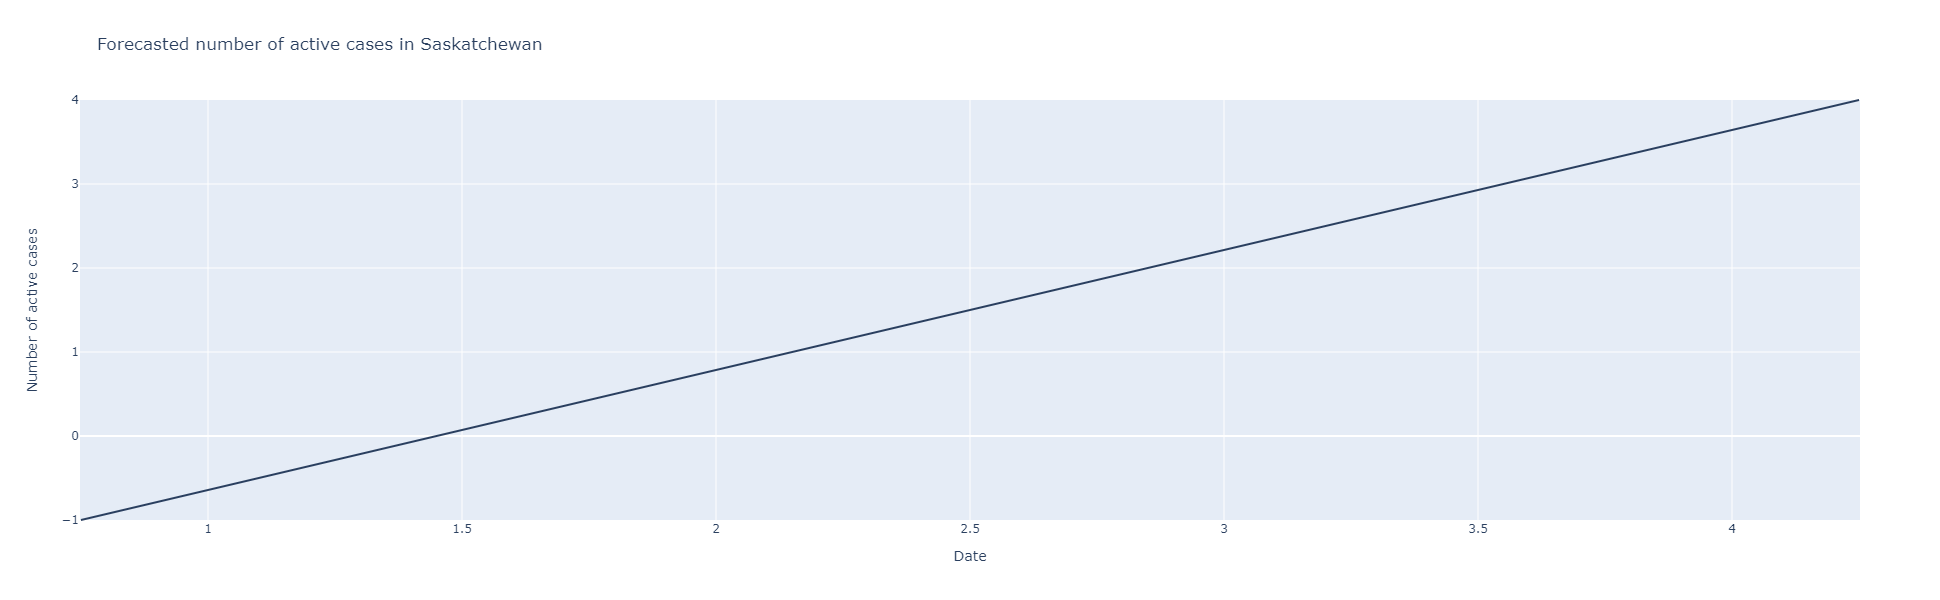

In [7]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative deaths",
        title=f"Forecasted cumulative deaths in {province}",
        height=600,
        include_ci=False,
    )

    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Number of active cases",
        title=f"Forecasted number of active cases in {province}",
        height=600,
    )

### Province tests

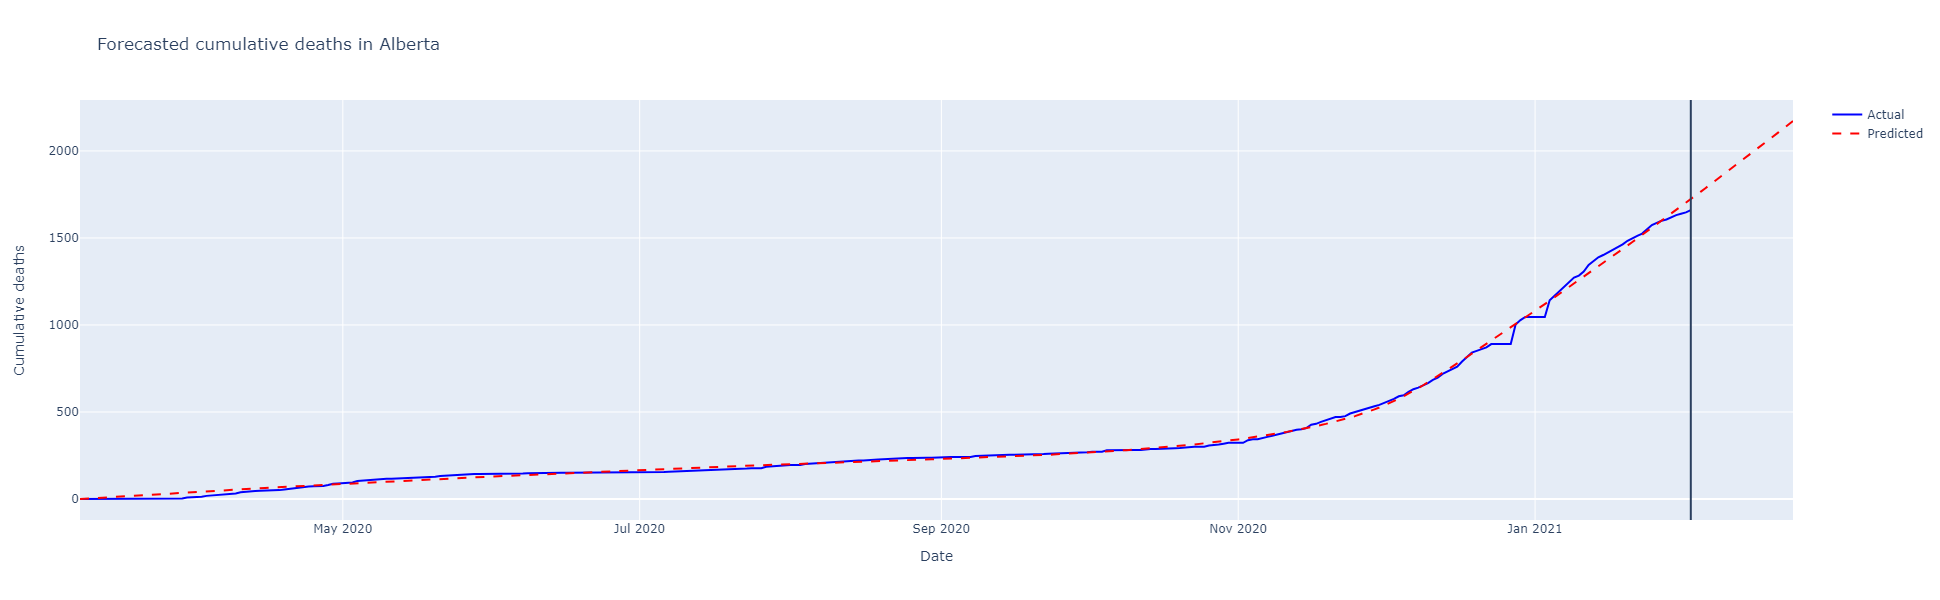

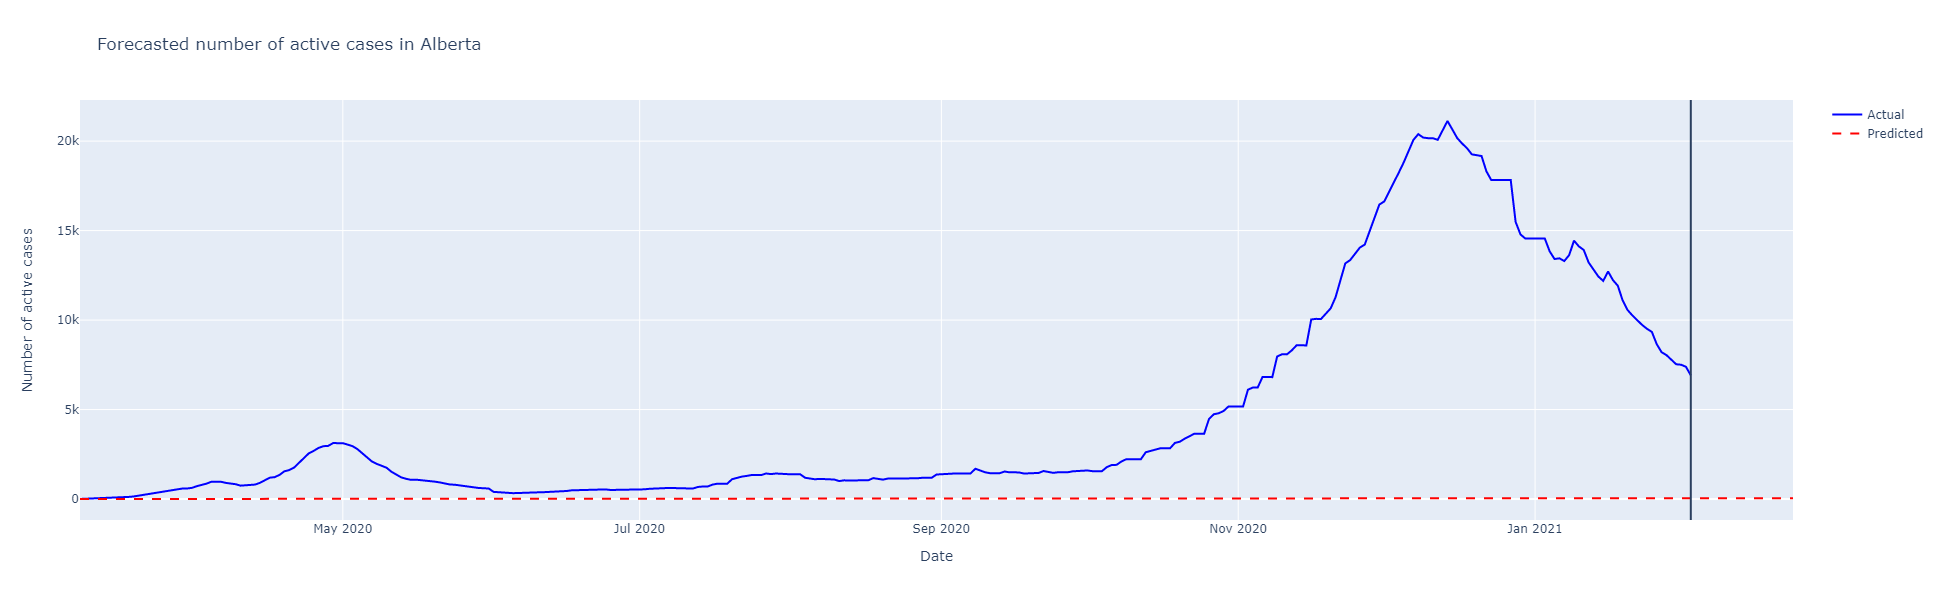

In [10]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()
province = "Alberta"

date_splits = get_prov_gov_policies(province)["date"].dt.date.tolist()

# Get province data
province_data = covid_data.query("province == @province")

# Fit SEIR model
model = SEIRModel(lam=1, method="L-BFGS-B", date_splits=date_splits, verbose=True)
model.fit(province_data)

# Get forecasts
province_forecasts = model.forecast(h=h)
forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)


plot_predictions(
    province_forecasts,
    y="cumulative_deaths",
    y_label="Cumulative deaths",
    title=f"Forecasted cumulative deaths in {province}",
    height=600,
    include_ci=False,
)

plot_predictions(
    province_forecasts,
    y="active_cases",
    y_label="Number of active cases",
    title=f"Forecasted number of active cases in {province}",
    height=600,
)

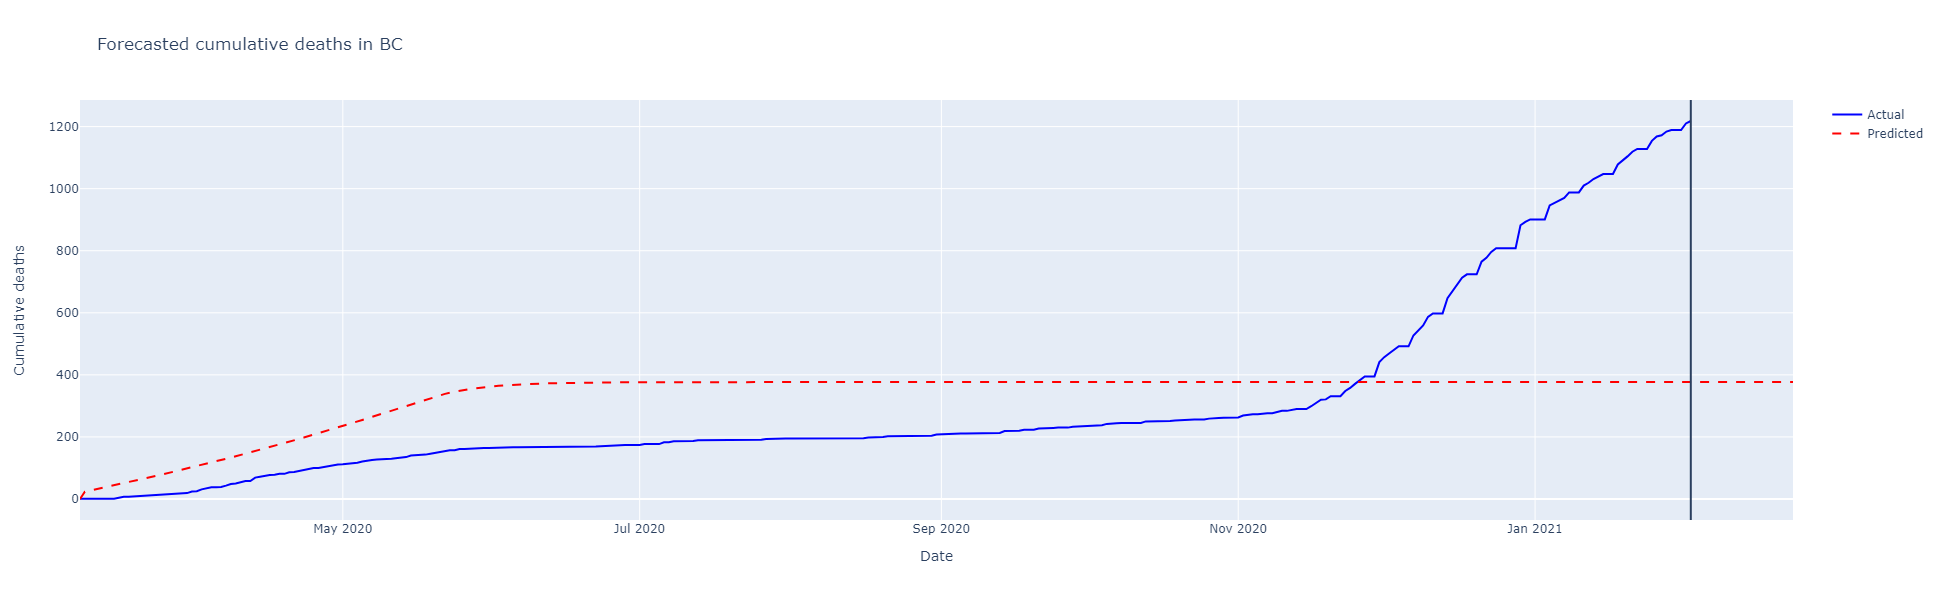

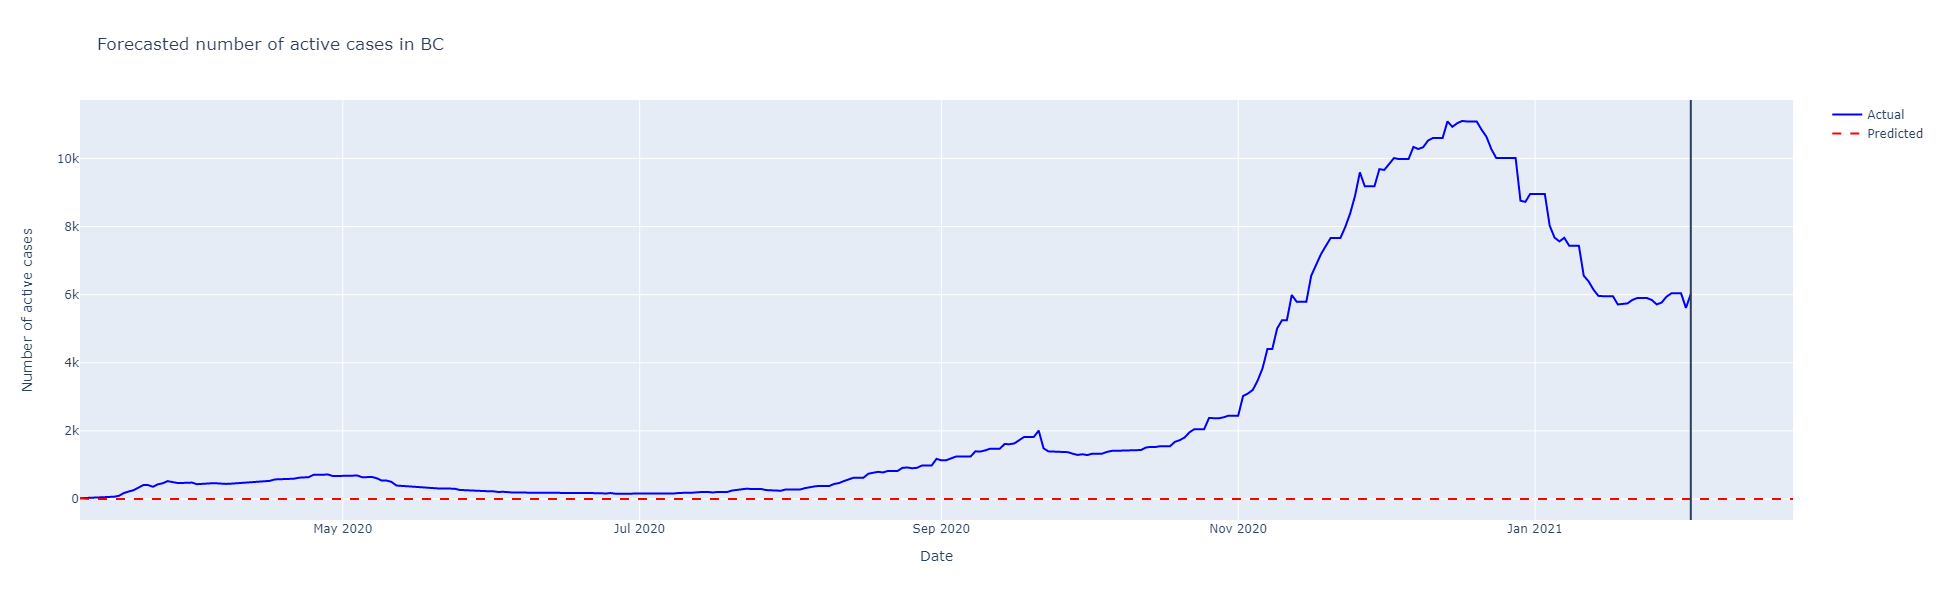

In [81]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()
province = "BC"

date_splits = get_prov_gov_policies(province)["date"].dt.date.tolist()

# Get province data
province_data = covid_data.query("province == @province")

# Fit SEIR model
model = SEIRModel(lam=1, method="L-BFGS-B", date_splits=date_splits, verbose=True)
model.fit(province_data)

# Get forecasts
province_forecasts = model.forecast(h=h)
forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)


plot_predictions(
    province_forecasts,
    y="cumulative_deaths",
    y_label="Cumulative deaths",
    title=f"Forecasted cumulative deaths in {province}",
    height=600,
    include_ci=False,
)

plot_predictions(
    province_forecasts,
    y="active_cases",
    y_label="Number of active cases",
    title=f"Forecasted number of active cases in {province}",
    height=600,
)

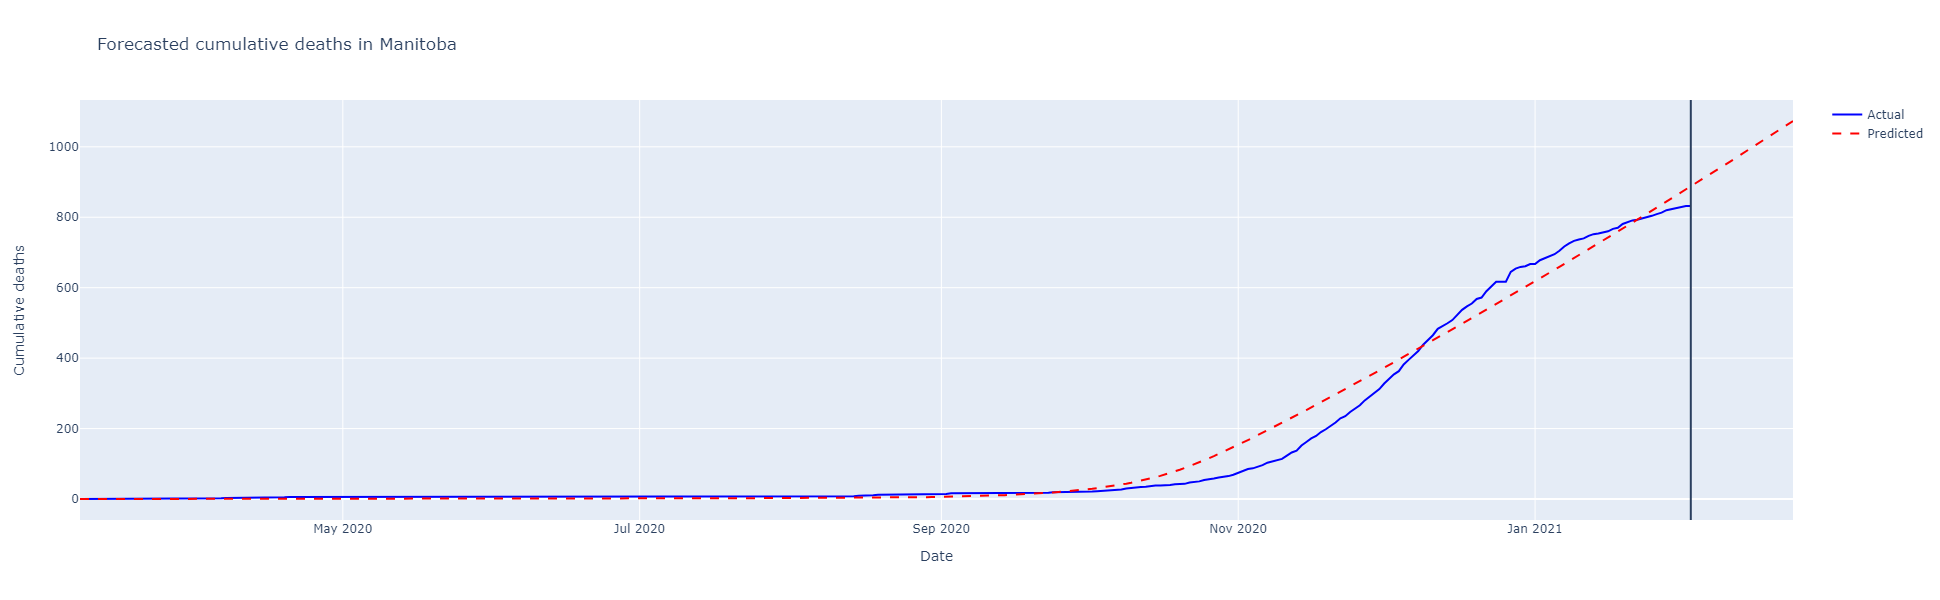

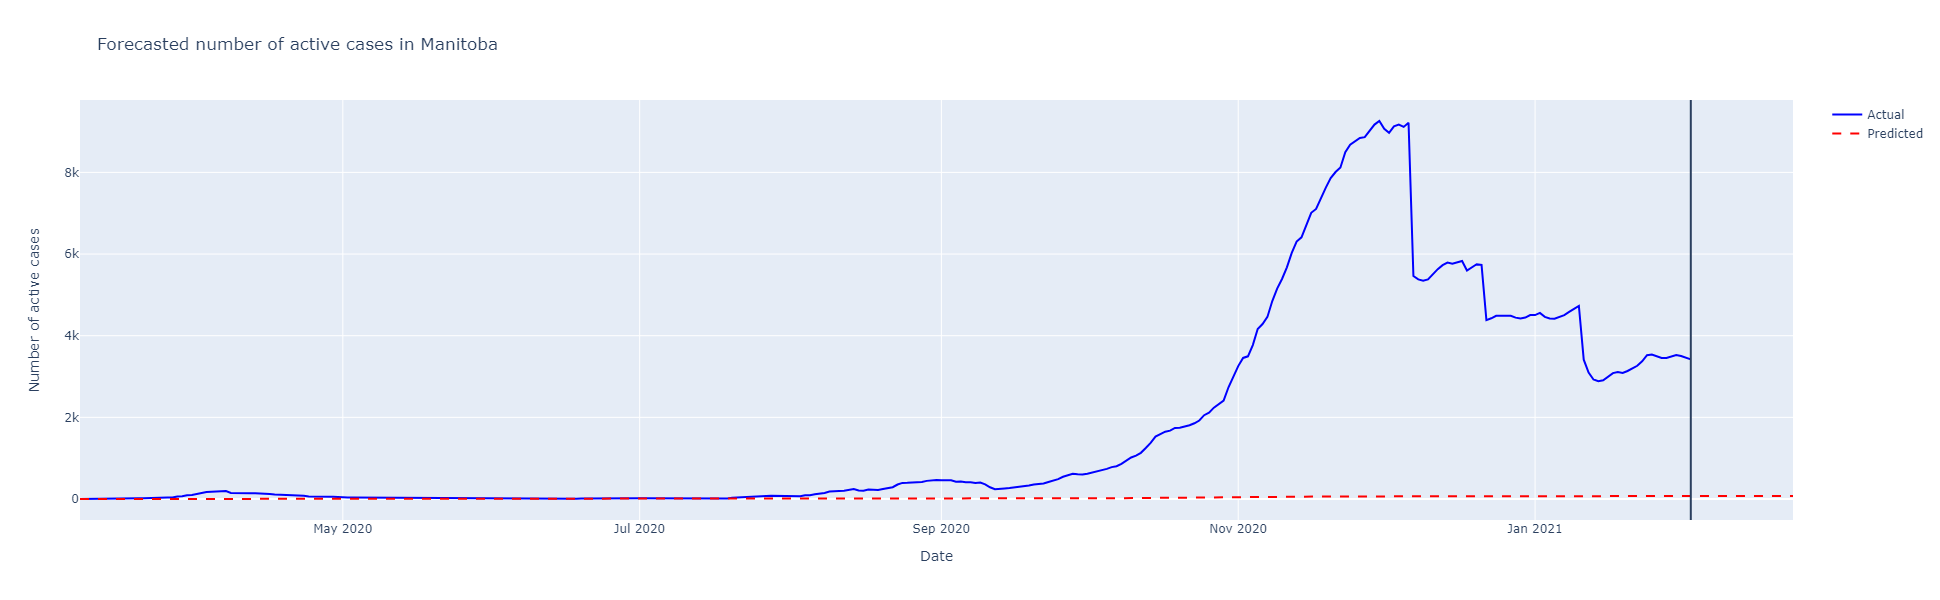

In [12]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()
province = "Manitoba"

date_splits = get_prov_gov_policies("BC")["date"].dt.date.tolist()

# Get province data
province_data = covid_data.query("province == @province")

# Fit SEIR model
model = SEIRModel(lam=1, method="L-BFGS-B", date_splits=date_splits, verbose=True)
model.fit(province_data)

# Get forecasts
province_forecasts = model.forecast(h=h)
forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)


plot_predictions(
    province_forecasts,
    y="cumulative_deaths",
    y_label="Cumulative deaths",
    title=f"Forecasted cumulative deaths in {province}",
    height=600,
    include_ci=False,
)

plot_predictions(
    province_forecasts,
    y="active_cases",
    y_label="Number of active cases",
    title=f"Forecasted number of active cases in {province}",
    height=600,
)

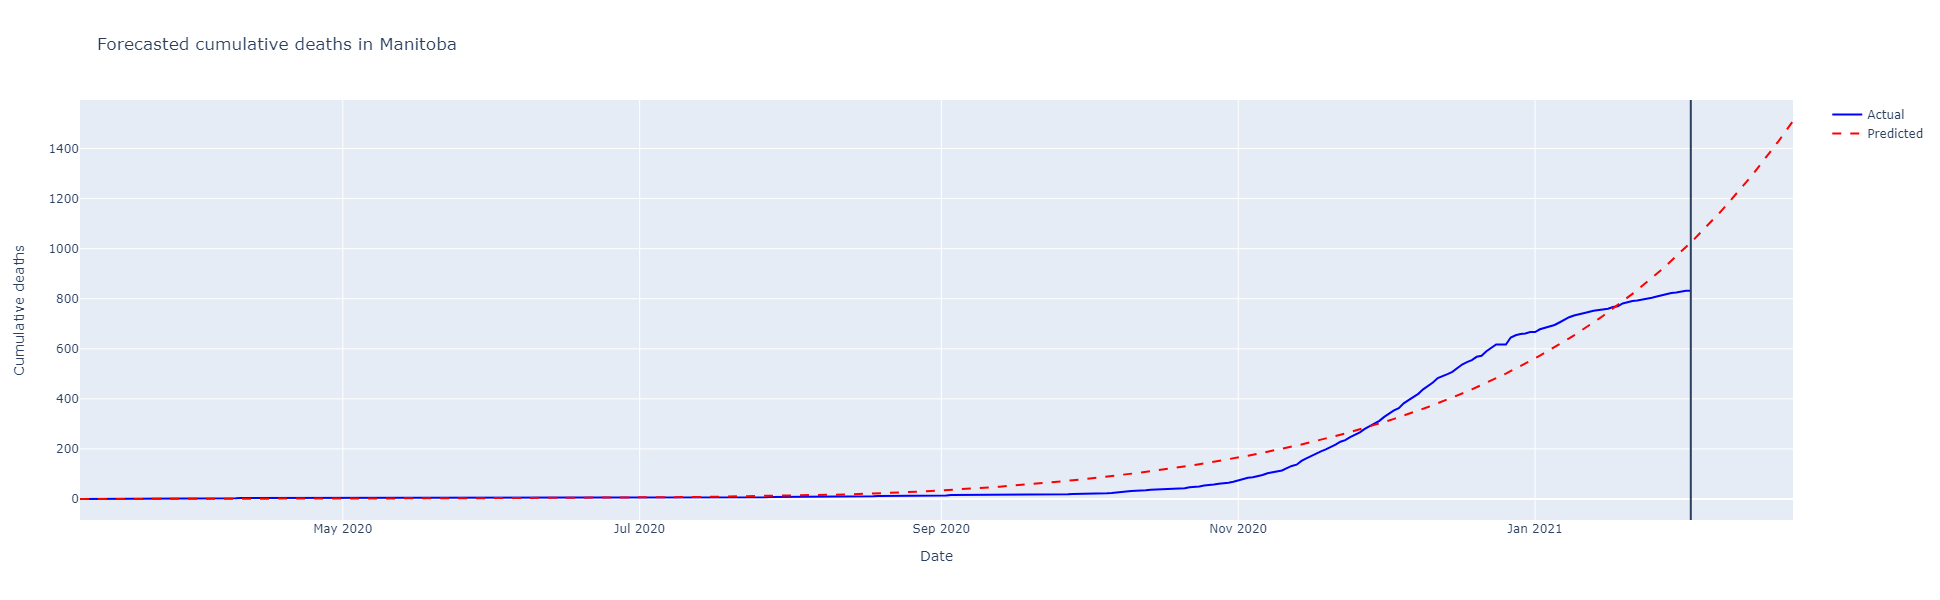

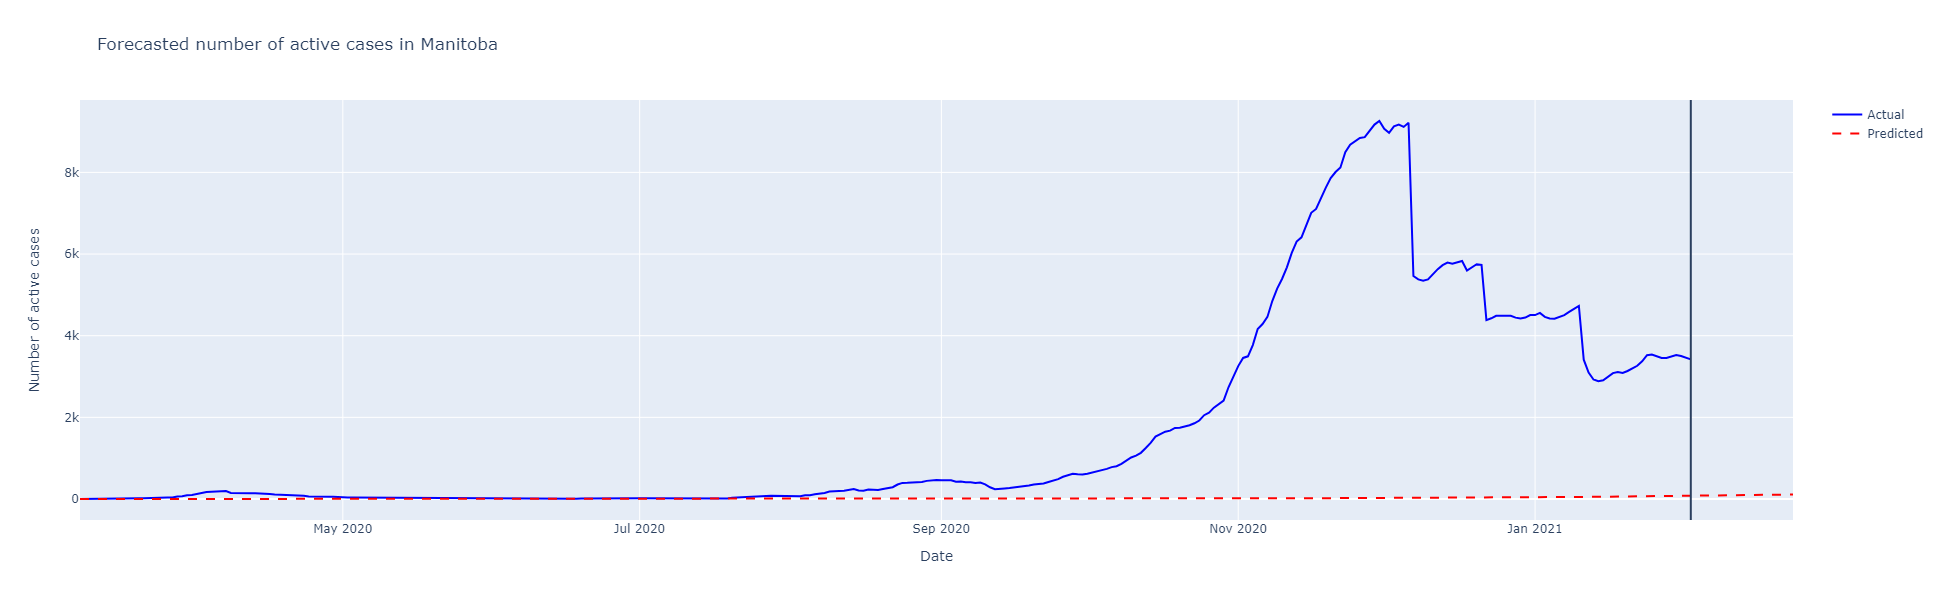

In [14]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()
province = "Manitoba"

date_splits = get_prov_gov_policies(province)["date"].dt.date.tolist()

# Get province data
province_data = covid_data.query("province == @province")

# Fit SEIR model
model = SEIRModel(lam=1, method="L-BFGS-B", date_splits=date_splits, verbose=True)
model.fit(province_data)

# Get forecasts
province_forecasts = model.forecast(h=h)
forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)


plot_predictions(
    province_forecasts,
    y="cumulative_deaths",
    y_label="Cumulative deaths",
    title=f"Forecasted cumulative deaths in {province}",
    height=600,
    include_ci=False,
)

plot_predictions(
    province_forecasts,
    y="active_cases",
    y_label="Number of active cases",
    title=f"Forecasted number of active cases in {province}",
    height=600,
)